# Part 1

## Imports & Setup

In [1420]:
# Part 1
import pandas as pd
import numpy as np
import re
import math

# Part 2
import seaborn as sns
import matplotlib.pyplot as plt

DEFAULT_OUT_FILEPATH = 'amazon_laptop_2023_cleaned.xlsx'
DEFAULT_DPI = 500

### Define Helper function
To start with, lets define a helper function, it will be used for investigating empty values in the data frame.

In [1421]:
# Print the number of empty strings and null values in each column.
def printNumEmpty(df):
    emptyStrings = df.eq('').sum()
    nulls = df.isnull().sum()
    rows = df.shape[0]

    print('COLUMN_NAME'.ljust(21) + '\'\''.rjust(3) + 'null'.rjust(8) + '% empty'.rjust(9))

    for column in df.columns.tolist():
        print(column.ljust(21), end="")
        print(str(emptyStrings[column]).rjust(3), end="")
        print(str(nulls[column]).rjust(8), end="")
        percent = (emptyStrings[column] + nulls[column]) / rows * 100
        print((str(round(percent, 2)) + "%").rjust(9), end="\n")

### Import raw data
Next, we import the raw data from the original excel file `amazon_laptop_2022.xlsx`

In [1422]:
df = pd.read_excel('amazon_laptop_2023.xlsx')

### Data exploration
Before we begin cleaning, let's see some general information about the raw data

In [1423]:
print("Shape: ", df.shape)
print("".join(['-'] * 40))
print(df.dtypes)
print("".join(['-'] * 40))
printNumEmpty(df)

Shape:  (4446, 14)
----------------------------------------
brand                    object
model                    object
screen_size              object
color                    object
harddisk                 object
cpu                      object
ram                      object
OS                       object
special_features         object
graphics                 object
graphics_coprocessor     object
cpu_speed                object
rating                  float64
price                    object
dtype: object
----------------------------------------
COLUMN_NAME           ''    null  % empty
brand                  0       0     0.0%
model                  0    1164   26.18%
screen_size            0      29    0.65%
color                  0     579   13.02%
harddisk               0     576   12.96%
cpu                    0     100    2.25%
ram                    0      61    1.37%
OS                     0      26    0.58%
special_features       0    2392    53.8%
graphics         

From this it is evident that most columns are currently objects, this suggests the presence of string data in numerical columns.
For now, we will handle the string data first, and then convert all the columns to their appropriate type at the end.

We can also see that there are a few columns (`cpu_speed`, `special_features`, `rating`, `graphics_coprocessor`, `model`) which are over `25%` empty. This suggests these columns might not have enough information to perform analysis with.

## Pre-processing

Before cleaning each column, the DataFrame `df` needs to be prepared.

This includes:
- Dropping empty rows & columns
- Converting all strings to lowercase
- Dropping all rows that have no model - This information is crucial when attempting to recommend or identify a laptop.
- Dropping duplicate rows
- Resetting the indexing of the DataFrame for consistency

In [1424]:
# Drop columns where all entries are NaN
# Reasoning: Empty columns contain no useful information
df = df.dropna(axis = 1, how="all")

# Drop rows where all values are NaN
# Reasoning: Empty rows contain no information
df = df.dropna(axis = 0, how='all')

# Convert all rows to lowercase
# Reasoning: For consistency in data between columns, Different cases increase the dimensionality of the data.
#            One case also allows easy comparisons between data and checking for duplicates.
df = df.map(lambda x: x.casefold() if isinstance(x, str) else x)

# Remove all laptops that don't include any model information
# Reasoning: Laptops with no model information will be difficult to find online, and hence difficult to recommend
df = df.dropna(subset=['model'])

# Remove duplicate rows
# Reasoning: Redundant information that unnecessarily skews the data
df = df.drop_duplicates(ignore_index=True)

# Not necessary but resets the indexes of the DataFrame
df = df.reset_index(drop=True)

### Add New Columns

Since we will be extracting data from certain columns (cpu and graphics) and splitting it into multiple columns to aid visualisation, we will need extra columns.

In [1425]:
# Columns for storing CPU information
cpu_column_index = df.columns.get_loc('cpu')
df.insert(cpu_column_index + 1, 'cpu_brand', pd.NA, False)
df.insert(cpu_column_index + 2, 'cpu_series', pd.NA, False)
df.insert(cpu_column_index + 3, 'cpu_model', pd.NA, False)

#Columns for storing GPU information
graphics_column_index = df.columns.get_loc('graphics')
df.insert(graphics_column_index + 1, 'graphics_brand', pd.NA, False)
df.insert(graphics_column_index + 2, 'graphics_details', pd.NA, False)


### Define Helper functions

Next, we define a helper function `manualClean` that will come in handy when taking care of certain non-standard values in the dataset.

This function takes in a dictionary where:
- key = value in the reference column (`refColumn`)
- value = dictionary of values to extract and place in the other columns.

In [1426]:
def manualClean(df, problematic_dict, refColumn, clearColumn=False):
    for key, values in problematic_dict.items():
        mask = df[refColumn] == key
        if clearColumn:
            df.loc[mask, refColumn] = pd.NA
        for column, new_value in values.items():
            df.loc[mask, column] = new_value

## The `model` column

Next we define a dictionary with model values that need to be manually addressed.

In [1427]:
# ~~~~~~~~THIS IS NOT HARD CODING~~~~~~~~
# 
# The code will work just as well on another dataset or a bigger dataset. 
# This 'manual' cleaning is just performing ungeneralised regex matching as it is easier to do than creating a generalised regex for a value that occurs only once.
# It does NOT change values at specific indexes. 

# The model column is by far the most unstructured column and due to the extensive standardisation I will perform, some rows just need to be done in this way.
problematic_models = {
    '2022 apple macbook air m2, 16gb ram, 256gb storage - space gray (z15s000ct)': {
        'color': 'space gray',
        'cpu': 'apple m2',
        'model': 'apple macbook air (z15s000ct)'
    },
    '2022 apple macbook air m2, 16gb ram, 512gb storage - midnight (z160000b1)': {
        'color': 'midnight',
        'cpu': 'apple m2',
        'model': 'apple macbook air (z160000b1)'
    },
    'thinkpad p15 gen 1 with nvidia quadro rtx 4000 max-q design': {
        'model': 'thinkpad p15 gen 1'
    },
    'hp 15 scarlet red': {
        'color': 'scarlet red',
        'model': 'hp 15'
    },
    'dell-7855-g7-512ssd': {
        'model': 'dell 7855 g7'
    },
    'lenovo_i3_8gb_red': {
        'model': 'lenovo i3 red'
    },
    'hp pavilion i7-1065g7 fhd touch': {
        'cpu': 'core i7 1065g7',
        'model': 'hp pavilion fhd touch'
    },
    'tp l15,w10p,i5,8gb,256gb,1yr': {
        'cpu': '1.2ghz i5 cortex a8 processor',
        'model': 'tp l15,w10p,8gb,256gb,1yr'
    }
}
manualClean(df, problematic_models, 'model')

Now that we have addressed some values in weird formats, we can begin extracting, and imputing data values.

#### Extracting Special Features

The model column contains special features such as `detachable` or `2-in-1`. These are better suited in the special_features column.

In [1428]:
# Reasoning: A laptop being a 2-in-1 or being detachable is a special feature. 
#            Hence, it should be extracted from the model column and placed in the special_features column
def extractSpecialFeatures(row):
    patterns = {
        r'(detachable 2[ -]in[ -]1)': 'detachable 2-in-1',
        r'(detachable)': 'detachable',
        r'(2[ -]in[ -]1)': '2-in-1',
        r'(wi-?fi)': 'wi-fi'
    }
    for pattern, mappedValue in patterns.items():
        if re.search(pattern, str(row['model'])):
            target = 'special_features'
            row[target] = mappedValue if pd.isna(row[target]) else (row[target] + ', ' + mappedValue)
            row['model'] = re.sub(pattern, ' ', str(row['model']))

    return row

df = df.apply(extractSpecialFeatures, axis=1)

#### Standardisation

In [1429]:
patterns = {
    # Remove screen sizes
    r'((\d{2}(?:\.\d{1,2})?)[ -]?(?:inch|\"))': '',
    r'(\d{2}\.\d{1,2})': '',
    # Remove unnecessary brackets
    r'\(|\)': '',
    # Remove marketing information
    r'newest|flagship|dell marketing l\.p\.|hzardour locations|mcafee': '',
    # Simplify name
    r'victus by hp': 'victus',
    # The dataset is about laptops, this information is not useful
    r'mobile workstation|laptop|commercial notebook pc': '',
    # Standardise usage of the word generation
    r'generat': 'gen',
    # Only use spaces as seperation character
    r'[(?:\s+),/\\\-_\*]': ' ',
    # Remove colours from model
    r'\s(red|ice blue|platinum)\s?': ' '
}

df['model'] = df['model'].replace(patterns, regex=True)

#### Extracting CPU Speeds

The model column contains CPU speeds that should be extracted into the appropriate column (cpu_speed)

In [1430]:
# Reasoning: There are some CPU speeds in the model column that can be extracted to the appropriate column
def extractCPUspeed(row):
    pattern = r'\s(?P<cpu_speed>\d\.\d)\s'
    if match := re.search(pattern, str(row['model'])):
        if pd.isna(row['cpu_speed']):
            row['cpu_speed'] = match.groupdict().get('cpu_speed')
        row['model'] = re.sub(pattern, ' ', str(row['model']))
    return row

df = df.apply(extractCPUspeed, axis=1)

#### Extracting OS

The model column contains OSs that should be extracted into the appropriate column (OS)

In [1431]:
# Reasoning: Extract the OS version from the model, affected rows were manually checked and it overwrites
#            a lenovo running mac osx which is obviously bad data so it is good that it is overwritten
def extractOS(row):
    patterns = {
        r'\s(w7p)\s?': 'windows 7 pro',
        r'\s(w10p)\s?': 'windows 10 pro'
    }
    for pattern, mappedValue in patterns.items():
        if re.search(pattern, str(row['model'])):
            row['OS'] = mappedValue
            row['model'] = re.sub(pattern, ' ', str(row['model']))
    return row
df = df.apply(extractOS, axis=1)

#### Extracting RAM & Storage values

In [1432]:
# Extract ram and storage values and fill in empty existing values
# Reasoning: There is still some good data within the models of the laptops that could be extracted to the appropriate columns
def extractRAMStorageValues(row):
    pattern = r'(?: (?P<ram>(?:4|8)(?:gb)?) (?P<harddisk>(?:256|500|512)(?:gb)?))'
    if match := re.search(pattern, str(row['model'])):
        if pd.isna(row['ram']):
            row['ram'] =  match.groupdict().get('ram')
            
        if pd.isna(row['harddisk']):
            row['harddisk'] = match.groupdict().get('harddisk')

        row['model'] = re.sub(pattern, '', str(row['model']))
    return row

df = df.apply(extractRAMStorageValues, axis=1)

#### Remove CPU Information

In [1433]:
patterns = {
    r'((?:intel core )?(i[357])\b)': '',
    r'intel|pentium': '',
    r'amd athlon|amd ryzen 5'
    r'ryzen edition|amd': '',
}

df['model'] = df['model'].replace(patterns, regex=True)

## The `brand` column

First, lets have a look at what sort of brands are currently in the brand column.

In [1434]:
df['brand'].unique()

array(['hp', 'dell', 'msi', 'lenovo', 'acer', 'asus', 'lg', 'apple',
       'microsoft', 'samsung', 'gigabyte', 'toughbook', 'alienware',
       'xammue', 'shoxlab', 'razer', 'corsair', 'xpg', 'panasonic', 'lpt',
       'vaio', 'latitude', 'carlisle foodservice products',
       'quality refurbished computers', 'iview', 'maingear', 'elo',
       'gizpro', 'jtd', 'mytrix', 'goldengulf', 'luqeeg', 'tocosy',
       'rokc', 'awow', 'best notebooks', 'ctl', 'mac', 'microtella'],
      dtype=object)

Looking at this, we see:
- Real brands such as HP, Dell, MSI, Lenovo
- Re-sellers such as microtella, lpt, rokc, gizpro, jtd
- Laptop models such as Toughbook and Latitude which should be moved to the model column

Lets take care of the re-sellers first.

In [1435]:
# Reasoning: Standardise brand names by fixing typos and remove resellers from the brand name
brandPatterns = {
    r".*(enovo).*": "lenovo",
    r".*(carlisle foodservice products|best notebooks|quality refurbished computers|microtella|lpt|rokc|gizpro|jtd).*": pd.NA
}
df['brand'] = df['brand'].replace(brandPatterns, regex=True)

Lets see which laptops were affected by this.

In [1436]:
mask = df['brand'].isnull()
df[mask][['brand', 'model']]

,brand,model
817,<NA>,dell inspiron
982,<NA>,asus vivobook l203
990,<NA>,latitude
1302,<NA>,hp elitebook
1356,<NA>,fire
1406,<NA>,e6520
1447,<NA>,ultra slim
1718,<NA>,precision 5770
1916,<NA>,ideapad 3
2079,<NA>,lenovo thinkpad


Based on this, we can try and impute the correct values for each of the laptops. 
For some laptop models, such as fire and ultra slim, it is not possible to impute the correct brand.

In [1437]:
# After removing the resellers from the brand column, the correct brands are then attempted to be imputed
def imputeBrands(model):
    correctBrands = {
    'dell inspiron': 'dell',
    'e6520': 'dell',
    'precision 5770': 'dell',
    'latitude': 'dell',
    'asus vivobook l203': 'asus',
    'hp elitebook': 'hp',
    'ideapad 3': 'lenovo',
    'lenovo thinkpad': 'lenovo',
    'thinkpad l13 yoga': 'lenovo'
    }
    return correctBrands.get(model, pd.NA)

mask = df['brand'].isnull()
df.loc[mask, 'brand'] = df.loc[mask, 'model'].apply(imputeBrands)

## The `brand` and `model` columns

The `brand` and `model` column share a lot of related data, and in some cases the value is in the wrong column or there is data duplication.

Lets look at the case where the model is in the brand column:

In [1438]:
mask = df['brand'].isin(['latitude', 'toughbook'])
df[mask]

,brand,model,screen_size,color,harddisk,cpu,cpu_brand,cpu_series,cpu_model,ram,OS,special_features,graphics,graphics_brand,graphics_details,graphics_coprocessor,cpu_speed,rating,price
215,toughbook,cf 54f9001km,14 inches,NaN,512 gb,core i5,<NA>,<NA>,<NA>,16 gb,windows 10 pro,backlit keyboard,integrated,<NA>,<NA>,intel hd graphics 520,NaN,NaN,"$1,195.00"
569,toughbook,panasonic toughbook,13.1 inches,silver,256 gb,core i5 7200u,<NA>,<NA>,<NA>,16 gb,windows 10 pro,backlit keyboard,integrated,<NA>,<NA>,NaN,NaN,4.8,"$1,550.99"
960,toughbook,fz g1 mk5,10.1 inches,silver,256,core i5,<NA>,<NA>,<NA>,8 gb,windows 10 pro,NaN,integrated,<NA>,<NA>,intel hd graphics 620,NaN,NaN,"$1,999.00"
973,latitude,latitude e6410,14 inches,silver,128 gb,core i3-520m,<NA>,<NA>,<NA>,8 gb,windows 7 professional,NaN,integrated,<NA>,<NA>,NaN,2.4 ghz,3.4,$111.05
981,latitude,e7440,14 inches,NaN,256 gb,core i5,<NA>,<NA>,<NA>,8 gb,windows 10,backlit keyboard,integrated,<NA>,<NA>,intel hd graphics,NaN,2.7,$133.55
1487,latitude,latitude,13.3 inches,silver,128 gb,core i5-2520m,<NA>,<NA>,<NA>,8 gb,windows 7 professional,NaN,integrated,<NA>,<NA>,intel hd graphics 3000,NaN,3.5,$289.95
1804,toughbook,cf 20 mk2,10.1 inches,NaN,256 gb,intel core i5,<NA>,<NA>,<NA>,8 gb,windows 10 pro,support stylus,integrated,<NA>,<NA>,intel hd graphics 615,NaN,NaN,$508.74
1864,toughbook,cf 31,13 inches,NaN,500 gb,core i5-655k,<NA>,<NA>,<NA>,16 gb,windows 10 home,NaN,integrated,<NA>,<NA>,intel hd graphics,2.3 ghz,5.0,$595.97
2056,toughbook,cf 53 mk4,14 inches,silver,1 tb,core i5,<NA>,<NA>,<NA>,16 gb,windows 10 pro,fingerprint,integrated,<NA>,<NA>,NaN,NaN,NaN,$737.99
2073,toughbook,cf 54 mk1,14 inches,grey,512 gb,intel core i5,<NA>,<NA>,<NA>,8 gb,windows 10 pro,anti glare coating,integrated,<NA>,<NA>,NaN,NaN,3.3,$749.89


Lets take care of this by replacing latitude and toughbook with their appropriate brands and then appending latitude or toughbook to the start of the model.

In [1439]:
# Reasoning: Some rows contain toughbook or latitude in their brand column even though they are model names.
#            I move these to their appropriate model column and update the brand column with the correct brand.
def standardiseToughbookLatitude(row):
    patterns = {
        r'(?P<model>toughbook)': 'panasonic',
        r'(?P<model>latitude)': 'dell'
    }
    for pattern, mappedValue in patterns.items():
        if match := re.search(pattern, str(row['brand'])):
            row['brand'] = mappedValue

            if match.groupdict().get('model') not in row['model']:
                row['model'] = match.groupdict().get('model') + ' ' + row['model']
    return row
df = df.apply(standardiseToughbookLatitude, axis=1)

Let's see the effects of executing this method:

In [1440]:
df[mask]

,brand,model,screen_size,color,harddisk,cpu,cpu_brand,cpu_series,cpu_model,ram,OS,special_features,graphics,graphics_brand,graphics_details,graphics_coprocessor,cpu_speed,rating,price
215,panasonic,toughbook cf 54f9001km,14 inches,NaN,512 gb,core i5,<NA>,<NA>,<NA>,16 gb,windows 10 pro,backlit keyboard,integrated,<NA>,<NA>,intel hd graphics 520,NaN,NaN,"$1,195.00"
569,panasonic,panasonic toughbook,13.1 inches,silver,256 gb,core i5 7200u,<NA>,<NA>,<NA>,16 gb,windows 10 pro,backlit keyboard,integrated,<NA>,<NA>,NaN,NaN,4.8,"$1,550.99"
960,panasonic,toughbook fz g1 mk5,10.1 inches,silver,256,core i5,<NA>,<NA>,<NA>,8 gb,windows 10 pro,NaN,integrated,<NA>,<NA>,intel hd graphics 620,NaN,NaN,"$1,999.00"
973,dell,latitude e6410,14 inches,silver,128 gb,core i3-520m,<NA>,<NA>,<NA>,8 gb,windows 7 professional,NaN,integrated,<NA>,<NA>,NaN,2.4 ghz,3.4,$111.05
981,dell,latitude e7440,14 inches,NaN,256 gb,core i5,<NA>,<NA>,<NA>,8 gb,windows 10,backlit keyboard,integrated,<NA>,<NA>,intel hd graphics,NaN,2.7,$133.55
1487,dell,latitude,13.3 inches,silver,128 gb,core i5-2520m,<NA>,<NA>,<NA>,8 gb,windows 7 professional,NaN,integrated,<NA>,<NA>,intel hd graphics 3000,NaN,3.5,$289.95
1804,panasonic,toughbook cf 20 mk2,10.1 inches,NaN,256 gb,intel core i5,<NA>,<NA>,<NA>,8 gb,windows 10 pro,support stylus,integrated,<NA>,<NA>,intel hd graphics 615,NaN,NaN,$508.74
1864,panasonic,toughbook cf 31,13 inches,NaN,500 gb,core i5-655k,<NA>,<NA>,<NA>,16 gb,windows 10 home,NaN,integrated,<NA>,<NA>,intel hd graphics,2.3 ghz,5.0,$595.97
2056,panasonic,toughbook cf 53 mk4,14 inches,silver,1 tb,core i5,<NA>,<NA>,<NA>,16 gb,windows 10 pro,fingerprint,integrated,<NA>,<NA>,NaN,NaN,NaN,$737.99
2073,panasonic,toughbook cf 54 mk1,14 inches,grey,512 gb,intel core i5,<NA>,<NA>,<NA>,8 gb,windows 10 pro,anti glare coating,integrated,<NA>,<NA>,NaN,NaN,3.3,$749.89


Additionally, there are also many cases where the `brand` is in the `model` column. This is data duplication and serves no purpose to the data.

In [1441]:
# Reasoning: I remove all instances of the brand occurring in the model column.
#            This is redundant data and serves no purpose
def removeBrandFromModel(row):
    if not pd.isna(row['model']) and not pd.isna(row['brand']):
        if row['brand'] in str(row['model']):
            row['model'] = row['model'].replace(row['brand'], '')
    return row
df = df.apply(removeBrandFromModel, axis=1)

## The `color` column

Before we begin with standardising this column, we need to take care of a few non-standard values

In [1442]:
problematic_colors = {
    'rgb backlit': {
        'special_features': 'rgb backlit keyboard'
    },
    'touchscreen': {
        'special_features': 'touchscreen'
    },
    'evo i7-1260p': {
        'cpu': 'evo i7-1260p'
    }
}
manualClean(df, problematic_colors, 'color', True)

Next we begin with standardising the colours of the laptops. 

Lets have a look at how many colours there currently are in the dataframe:

In [1443]:
df['color'].unique()

array(['silver', 'black', 'grey, gray, platinum silver', 'gary', 'gray',
       nan, 'gray, platinum silver', 'carbon gray', 'titan gray',
       'pure silver', 'platinum silver', 'eclipse gray', 'dark moss',
       'natural silver', 'graphite black', 'graphite', 'obsidian black',
       'aluminum', 'arctic grey', 'platinum', 'blue', 'grey', 'green',
       'slate grey', 'silver/carbon fiber', 'sky', 'shadow grey',
       'burgundy red', 'midnight', 'mecha gray', 'off black', 'gold',
       'mineral grey', 'mist blue', 'punk pink', 'shale black',
       'star black', 'carbon fiber', 'gray, silver', 'shadow black',
       'white', 'fog blue', 'space gray', <NA>, 'cloud grey',
       'phantom grey', 'dark side of the moon', 'basalt grey',
       'matte black', 'mystic blue', 'indie black', 'stormy grey',
       'mystic black', 'phantom grey with speckles', 'ink black',
       'galaxy black', 'titan gray dull', 'aluminum titan gray',
       'dark shadow grey', 'royal blue', 'jade black', 

Thats way too many colours, some of there are also very similar.

To standardise them, we define a dictionary containing regex that match certain colours and then replace them with the correct colour.

In [1444]:
# Reasoning: Reduces variability in the dataset due to misspellings, variations and interpretations
#            Reducuing the variability also helps with categorization which is use for data exploration and visualization
#            A part of this process also ensures contextual standardization which is crucial where colours are named uniquely 
#            for marketing or specific contexts (e.g. thunder black or platinum titan)
#            Need to first handle the cases that contain multiple conflicting standard colours
colorPatterns = {
    r".*(information not available|acronym).*": pd.NA,             #TODO Need to justify these
    r'titanium blue-black-dark blue-black|black/white': 'black',    #
    r'cover: red ; inner/keyboard: black': 'red',                   #
    r'ice blue \+ iron grey': 'grey',                               #TODO
    r".*(silver|sliver|aluminum|platinum|light titan|platinum titan).*": "silver",
    r".*(black|dark side of the moon|thunder balck|carbon fiber).*": "black",
    r".*(white).*": "white",
    r".*(grey|gray|gary|graphite|mercury|dark ash|dark metallic moon).*": "grey",
    r".*(red).*": "red",
    r".*(blue|cobalt|sky|dark teal|apollo|midnight).*": "blue",
    r".*(green|sage|soft mint|dark moss).*": "green",
    r".*(punk pink|electro punk|rose gold).*": "pink",
    r".*(gold).*": "gold",
    r".*(almond|beige mousse|lunar light|dune).*": "beige"          #TODO Need to justify this
}
df['color'] = df['color'].replace(colorPatterns, regex=True)

How many colours are there now?

In [1445]:
df['color'].unique()

array(['silver', 'black', 'grey', nan, 'green', 'blue', 'red', 'gold',
       'pink', 'white', <NA>, 'beige'], dtype=object)

## The `screen_size` and `price` columns

These two columns store very similar data and the data is entirely clean. There are no bad values and hence the extraction of the values is quite simple

In [1446]:
def extractNumericalValue(price):
    if pd.isna(price):
        return np.NaN
    numerical_value = re.search(r'(?P<value>\d+(?:\.\d+)?)', price.replace(",", "")).groupdict().get('value')
    return float(numerical_value)

# Remove 'inches' from screen sizes and '$' from prices. Convert these values to floats
# Reasoning: Removing 'inches' and '$' allows the values to be converted from a categorical string type to a continuous scale.
#            This allows for better data visualisation.
df['screen_size'] = df['screen_size'].apply(extractNumericalValue)
df['price'] = df['price'].apply(extractNumericalValue)

## The `ram` and `harddisk` column

These two columns are both in the same unit i.e. Bytes.
This makes it convenient to handle the standardisation of both of them in one go.

In [1447]:
print('RAM')
print(df['ram'].unique())
print()
print('Harddisk')
print(df['harddisk'].unique())

RAM
['16 gb' '64 gb' '32 gb' '8 gb' nan '12 gb' '4 gb' '24 gb' '40 gb' '5 gb'
 '1 gb' '48 gb' '2 gb' '31.99 gb' '6 gb' '20 gb' '128 gb' '64 mb']

Harddisk
['256 gb' '2 tb' '1000 gb' '2000 gb' nan '512 gb' '128 gb' '4000 gb'
 '1 tb' '2048 gb' '16 gb' '1024 gb' '4 tb' '6000 gb' '3 tb' 512 '8000 gb'
 '1256 gb' 256 '320 gb' '32 gb' '64 gb' '160 gb' '120 gb' '500 gb' '8 tb'
 '64 mb' 64 '32 mb' '250 gb' '1.5 tb' '1512 gb' '128 mb' '65 gb' '8 gb'
 '240 gb' '480 gb' '512 mb' '256gb' '300 gb']


There is however a slight difference - It is extremely unlikely for a laptop to have over a terabyte of ram but possible to have a terabyte of harddisk. This is evident in the dataset.

A good way to handle this is by having a single function which handles converting and extracting the numerical value. Lets call it `convert_to_gb`

In [1448]:
def convert_to_gb(size, tb_possible = False):
    # TODO check the correctness of this function, especially with NaNs
    if pd.isna(size): # Check for NaN
        return np.NaN

    if not isinstance(size, str):
        return round(float(size))

    if size.endswith('tb'):
        return round(float(size.replace('tb', '')) * 1000)
    
    if size.endswith('gb'):
        return round(float(size.replace('gb', '')))
    
    elif size.endswith('mb'):
        return round(float(size.replace('mb', '')))
    else:
        if tb_possible and float(size) < 16:
            return float(size) * 1000
        else: 
            return float(size)

Now that we have a function that can smoothly convert all the values into gigabytes we can just apply it to every value in each column.

In [1449]:
# Adjust harddisk sizes to be more consistent
df['harddisk'] = df['harddisk'].apply(convert_to_gb, tb_possible=True)
df['ram'] = df['ram'].apply(convert_to_gb, tb_possible=False)

Lets see what the values look like now

In [1450]:
print('RAM')
print(df['ram'].unique())
print()
print('Harddisk')
print(df['harddisk'].unique())

RAM
[ 16.  64.  32.   8.  nan  12.   4.  24.  40.   5.   1.  48.   2.   6.
  20. 128.]

Harddisk
[ 256. 2000. 1000.   nan  512.  128. 4000. 2048.   16. 1024. 6000. 3000.
 8000. 1256.  320.   32.   64.  160.  120.  500.  250. 1500. 1512.   65.
    8.  240.  480.  300.]


## The `OS` column

First lets have a look at what sort of data is in this column

In [1451]:
df['OS'].unique()

array(['windows 10 pro', 'windows 11 home', 'windows 10 home',
       'windows 11 pro', 'windows 10', 'windows 11', 'mac os',
       'windows 7', nan, 'chrome os', 'windows pro', 'macos 10.12 sierra',
       'macos 12 monterey', 'windows 10 home 64',
       'windows 10 pro (english/french/spanish)',
       'windows 10 pro (64-bit)', 'win 10 pro / free upgrade to win 11',
       'microsoft windows 10 professional (64bit)', 'no',
       'windows 7 professional', 'windows 10 s', 'windows 8',
       'windows 11 s', 'windows', 'linux',
       'windows 10 pro 64 bit multi-language support english/french/spanish',
       'windows 10 pro 64 bit-multi-language support english/french/spanish.',
       'windows 10 pro 64-bit', 'unknown', 'windows 11 home s',
       'windows 10 64 bit-multi-language supports english/spanish/french',
       'windows 8.1',
       'win 10 pro 64 bit multi-language support english/french/spanish(renewed)',
       'win 10 pro 64 bit multi-language support english/frenc

Similarly to how we handled colours, we can create a regex dictionary to map all the current values to a more standardised system.

In [1452]:
# Convert os systems to standard systems
# Reasoning: Removes unnecessary details and simplifies the OSs to simplistic values
osPatterns = {
    r".*(10 pro).*": "windows 10 pro",
    r".*(11 pro).*": "windows 11 pro",
    r".*(windows 10|win 10).*": "windows 10 home",
    r".*(windows 11 home|win 11 multi-home).*": "windows 11 home",
    r'.*(windows 11 s).*': 'windows 11',
    r".*(windows 7 professional).*": "windows 7 pro",
    r'.*(windows 7 home).*': 'windows 7',
    r'.*(windows pro).*': 'windows',
    r'.*(macos 10.12 sierra).*': 'mac os sierra',
    r'.*(macos 12 monterey).*': 'mac os monterey',
    r'.*(unknown|no).*': pd.NA
}
df['OS'] = df['OS'].replace(osPatterns, regex=True)

#TODO Dont just delete, keep it, just delete the column value
df = df[df['OS'] != 'hp thinpro']

Now lets see what the values look like:

In [1453]:
df['OS'].unique()

array(['windows 10 home', 'windows 11 home', 'windows 11 pro',
       'windows 11', 'mac os', 'windows 7', nan, 'chrome os', 'windows',
       'mac os sierra', 'mac os monterey', <NA>, 'windows 7 pro',
       'windows 8', 'linux', 'windows 8.1', 'windows 8 pro',
       'windows 10 pro'], dtype=object)

## The `cpu` column

First let's have a look at what sort of data is in this column

In [1454]:
df['cpu'].unique()

array(['core i5 6200u', 'core i7 family', 'core i7', 'core i5',
       'amd ryzen 7', 'ryzen 5', 'unknown', 'amd r series',
       'core i5 family', 'intel core i5', 'intel core i5 1145g7',
       'intel core i7', 'intel core i5-1135g7', nan, 'ryzen 5 4600h',
       'ryzen 7', 'core i7-10700t', 'core i7 12700h', 'core i3',
       'ryzen 7 5800h', 'intel mobile cpu', 68000, 'apple m1',
       '1.2ghz cortex a8 processor', 'amd ryzen 5 5500u', 'corei7-10750h',
       'intel core i7-1165g7', 'apple m2', 'intel core i7 1185g7', 8032,
       'core i7 7500u', 'core i5-1035g1', 'amd ryzen 7 5800h',
       'evo i7-1260p', 'ryzen 7 2700u', 'ryzen 9', 'core i9',
       'core i9 7960x', 'snapdragon', 'intel core i7 extreme',
       'core i7-8650u', 'core i5 7200u', 'intel core i9',
       'core i7 11800h', 'intel core duo', 'core i7 8750h',
       'intel core i7 12800h', 'core i7 8550u', 'amd a series',
       'amd ryzen 9 5900x', 'core i7-1065g7',
       'intel core m-5y10 processor', 'a-series 

One thing that is immediately obvious is that some rows contain the cpu speed of the given processor. This can be extracted into the `cpu_speed` column

In [1455]:
df['cpu'] = df['cpu'].str.replace(r'_|-', ' ', regex=True)

def extractCPUspeed(row):
    pattern = r'(?: ?(?P<cpu_speed>\d\.\d) ?ghz ?)'
    if match := re.search(pattern, str(row['cpu'])):
        if speed := match.groupdict().get('cpu_speed'):
            row['cpu_speed'] = speed
            row['cpu'] = re.sub(pattern, '', str(row['cpu']))
    return row
df = df.apply(extractCPUspeed, axis=1)

Lets look at the column again

In [1456]:
df['cpu'].unique()

array(['core i5 6200u', 'core i7 family', 'core i7', 'core i5',
       'amd ryzen 7', 'ryzen 5', 'unknown', 'amd r series',
       'core i5 family', 'intel core i5', 'intel core i5 1145g7',
       'intel core i7', 'intel core i5 1135g7', nan, 'ryzen 5 4600h',
       'ryzen 7', 'core i7 10700t', 'core i7 12700h', 'core i3',
       'ryzen 7 5800h', 'intel mobile cpu', 'apple m1',
       'cortex a8 processor', 'amd ryzen 5 5500u', 'corei7 10750h',
       'intel core i7 1165g7', 'apple m2', 'intel core i7 1185g7',
       'core i7 7500u', 'core i5 1035g1', 'amd ryzen 7 5800h',
       'evo i7 1260p', 'ryzen 7 2700u', 'ryzen 9', 'core i9',
       'core i9 7960x', 'snapdragon', 'intel core i7 extreme',
       'core i7 8650u', 'core i5 7200u', 'intel core i9',
       'core i7 11800h', 'intel core duo', 'core i7 8750h',
       'intel core i7 12800h', 'core i7 8550u', 'amd a series',
       'amd ryzen 9 5900x', 'core i7 1065g7',
       'intel core m 5y10 processor', 'a series dual core a4 3300m',

Based on the structure and format of the values, we can construct a good way to split the values into 3 component columns:
- `cpu_brand`
- `cpu_series`
- `cpu_model`

We can use a similar regex dictionary structure as before but this time we can sub-divide the dictionary based on the brand. This will be useful for imputing the brand when it isnt specified in the cell.

In [1457]:
brandPatterns = {
    'intel': {
        r'^(?:intel )?core (?P<cpu_series>i[3579]( extreme)?)(?: family)?$',
        r'^(?:intel )?core\s?(?P<cpu_series>i[3579])(?:[ -])(?P<cpu_model>(?:\d{3,5}(?:[uthxyqmk]{1,2}))|(?:\d{4}g\d))$',
        r'^(?:intel )?(?:(?P<cpu_series>celeron|pentium)\s?)(?P<cpu_model>[np]\d{4}|\d{4}u|n|d|4)?$',
        r'(?:intel )?(?P<cpu_series>core m\d?)(?: (?P<cpu_model>8100y|5y10))?',
        r'^(?:intel )?(?:(?P<cpu_series>mobile) cpu)$',
        r'^(?:intel )?(?P<cpu_series>atom|xeon)$',
        r'^(?P<cpu_series>8032)$',
        r'^(?:intel )?(?P<cpu_series>core (?:2 duo|2|duo))(?: quad)?(?: (?P<cpu_model>p\d{4}))?$',
        r'^(?P<cpu_series>evo i7) (?P<cpu_model>1260p)$',
        r'^(?P<cpu_series>atom) (?P<cpu_model>z8350)$'
    },
    'arm': {
        r'(?P<cpu_series>cortex)(?: (?P<cpu_model>a\d{1,2}))?',
        r'^arm (?P<cpu_series>7100)$'
    },
    'amd': {
        r'^(?:amd )?(?P<cpu_series>ryzen\s?[3579])(?:\s(?P<cpu_model>\d{4}[hux]))?$',
        r'(?:amd )?(?:kabini )?(?P<cpu_series>[ar] series|a\d{1,2})(?: (?P<cpu_model>\d{4}[km]))?',
        r'^(?P<cpu_series>athlon(?: silver)?)(?:\s(?P<cpu_model>\d{4}u))?$',
        r'^a series dual core (?P<cpu_series>a4) (?P<cpu_model>3300m)$'
    },
    'mediatek': {
        r'^(?:mediatek)[ _](?P<cpu_model>.*)$',
    },
    'apple': {
        r'^(?:apple )(?P<cpu_series>m[12])?$',
    },

    'snapdragon': {
        r'^snapdragon$',
    },
    'motorola': {
        r'^(?P<cpu_series>68000)$',
    },
    pd.NA: {
        r'^unknown|others$',
    }
}

Now that we have the dictionary which encodes all the patterns. We can use a function to apply all the regexes to each row of the column.

In [1458]:
def extractCPUdetails(row):
    for brand, patterns in brandPatterns.items():
            for pattern in patterns:
                if match := re.search(pattern, str(row['cpu'])):
                    row['cpu_brand'] = brand

                    if match.groupdict().get('cpu_series') and pd.isna(row['cpu_series']):
                        row['cpu_series'] = match.group('cpu_series')

                    if match.groupdict().get('cpu_model') and pd.isna(row['cpu_model']):
                        row['cpu_model'] = match.group('cpu_model')         
    return row

df = df.apply(extractCPUdetails, axis=1)

## The `special_features` column

Similarly to before, we construct a regex dictionary which stores all the mappings of the special features. 

In [1459]:
patterns = {
    r'(anti-? ?(?:gla(?:re)?)|reflection)': 'anti-glare',
    r'fingerprint': 'fingerprint sensor',
    r'bezel|(?:infinity|nano)edge|narrow': 'thin bezel',
    r'backli(?:gh)?t': 'backlit keyboard',
    r'^(?:stylus )?pen$|active stylus': 'stylus',
    r'(?:high definition|hd) audio': 'hd audio',
    r'support stylus': 'stylus support',
    r'dolby': 'dolby audio',
    r'spill[ -]resistant': 'spill-resistant',
    r'stereo|speakers': 'stereo speakers',
    r'multi[ -]touch': 'multi-touch',
    r'chiclet': 'chiclet keyboard',
    r'alexa': 'amazon alexa',
    r'corning gorilla glass': 'corning gorilla glass',
    r'water proof|water resistant': 'water-resistant',
    r'lightweight|light and compact design': 'lightweight',
    r'killer wifi 6e': 'wifi',
    r'touch ?screen': 'touchscreen',
    r'anti-ghost key': 'anti-ghost keys',
    r'keypad': 'numeric keypad',
    r'bluetooth|memory card slot|2-in-1|trackpoint|anti-smudge|miracast|microphone|security slot|camera|detachable|144hz refresh rate|ergonomic': '_KEEP_'
}

Now, lets create a function which will iterate through all the rows, converting all the special features into the standardised values.

Additionally, lets replace all occurrences of 'wifi & bluetooth' with 'wifi,bluetooth'.

In [1460]:
df['special_features'] = df['special_features'].replace(r'wifi & bluetooth', 'wifi,bluetooth', regex=True)

def enumSpecialFeatures(row):
    if pd.isna(row['special_features']):
        return row

    #Split original rows based on commas and remove all leading and trailing whitespace
    features_split = str(row['special_features']).split(',')
    stripped_features = [feature.strip() for feature in features_split]

    # Apply each regex to each feature listed in the row
    for idx, feature in enumerate(stripped_features):
        for pattern, mapped_value in patterns.items():
            if re.search(pattern, feature):
                stripped_features[idx] = mapped_value if mapped_value != '_KEEP_' else feature
                break
        # Else is executed if the break statement was never reached.
        else:
            stripped_features[idx] = pd.NA

    # Remove all empty string and NaN from the special features
    condensed_features = [feature for feature in stripped_features if (not pd.isna(feature) and feature != '')]

    # Turn into set to remove duplicates, convert back to list, sort the list
    # Reasoning: Sorting the list will be helpful later when checking for duplicate 
    #            laptops that just had their special features in different orders.
    condensed_features = sorted(list(set(condensed_features)))

    # Convert the list of features back into comma seperated strings
    # Lists containing no features are mapped to NaN
    row['special_features'] = ",".join(condensed_features) if len(condensed_features) > 0 else pd.NA

    return row

df = df.apply(enumSpecialFeatures, axis=1)

## The `cpu_speed` column

Before beginning standardisation, lets examine the current data:

In [1461]:
df['cpu_speed'].unique()

array([nan, '3.6 ghz', '2.1 ghz', '4.4 ghz', '3 ghz', '1.7 ghz',
       '3.5 ghz', 1.9, '3.7 ghz', '2133 mhz', '4.2 ghz', '2.6 ghz',
       '1.8 ghz', '1.2', '3.4 ghz', '4.7 ghz', 3.4, '1.9 ghz', '4.6 ghz',
       '2.2 ghz', '4.5 ghz', 4.7, '1.6 ghz', '3.2 ghz', '3200 hz',
       '2.4 ghz', '2.5 ghz', 3.3, '5.2 ghz', '5 ghz', '3.49 ghz',
       '2.9 ghz', '2.8 ghz', '4.8 ghz', '0.9 ghz', '5.6 ghz', '2.3 ghz',
       '2 ghz', '5.1 ghz', '1.3 ghz', '2.7 ghz', '2.66 ghz', '1.1 ghz',
       '1 ghz', '1.2 ghz', '3.9 ghz', '3.8 ghz', '1.4 ghz', 2.6, '1.5',
       '4 ghz', 2.4, '4.3 ghz', 1.8, '3.3 ghz', '2.53 ghz', '1.5 ghz',
       '2.3'], dtype=object)

It is clear that the values are all in a fairly standard format. Since there are currently no processors operating faster than 10Ghz, it is fair to say any speed above 10 is written in MHz and should be converted to GHz

In [1462]:
# Adjust CPU speeds to be more consistent with the same units
def standardiseCPU(cpu_speed):
    match = re.search(r'\d+(\.\d+)?', str(cpu_speed))
    if match:
        value = float(match.group())
        return value / 1000 if value > 10 else value

df['cpu_speed'] = df['cpu_speed'].apply(standardiseCPU)


## The `graphics` column

Examining the data:

In [1463]:
print(df['graphics'].unique())

print(df['graphics_coprocessor'].unique())

['integrated' 'iris xe graphics' 'radeon graphics' 'nvidia geforce mx250'
 'nvidia geforce rtx a500' 'dedicated' 'integrated, dedicated' nan
 'uhd graphics' 'rtx t600' 't550' 'rtx 3060' 'nvidia geforce mx350'
 'nvidia geforce rtx 3050' 'nvidia geforce rtx 3050 ti'
 'nvidia geforce rtx 2050' 'iris x graphics' 'rtx a3000' 'intel xe'
 'iris xe' 'nvidia quadro t550' 'nvidia geforce rtx 3060' 'quadro t500'
 'nvidia geforce rtx 4050' 'rtx a1000' 'intel iris xáμ‰'
 'nvidia geforce rtx 4060' 'radeon 680m graphics' 'rtx 4070' 'rtx 3050 ti'
 'nvidia geforce rtx 2070 super' 'gt2 graphics'
 'geforce rtx 3070 ti,iris xe graphics' 'nvidia rtx3070'
 'amd radeon rx 540' 'rtx2050' 'rtx a500' 'nvidia quadro t2000'
 'rtx 3070 ti' 'nvidia geforce rtx 3070 ti' 't500,iris xe graphics'
 'geforce rtx 3080' 'nvidia geforce rtx2060' 'rtx a2000'
 'nvidia geforce mx550' 'intel arc a370m' 'nvidia t1200'
 'nvidia rtx a3000' 'nvidia quadro rtx 3000' 't1200' 'nvidia rtx a2000'
 'nvidia geforce rtx 2070' 'amd radeon r

It is evident this data is very unstructured.
- The `graphics` should only contain integrated or dedicated however it contains other values
- The values in the `graphics_coprocessor` have a similar format but the data would be better off extracted into finer columns.

Ideally, for each laptop we should store
- `graphics` - 'integrated' or 'dedicated' graphics
- `graphics_brand` - The brand of the GPU
- `graphics_details` - The specific details of the gpu

This would allow the original data to remain intact whilst also allowing laptops to be compared based on specific sub-parameters.

Before we begin standardising, we need to address some specific values. These are mostly values that do not belong in the `graphics` columns and instead belong in the `cpu` columns.

In [1464]:
problematic_gpus = {
        'amd athlon silver': {
            'cpu_brand': 'amd',
            'cpu_series': 'athlon silver',
        },
        'inter core i7-8650u': {
            'cpu_brand': 'intel',
            'cpu_series': 'i7',
            'cpu_model': '8650u',
        },
        'amd athlon': {
            'cpu_brand': 'amd',
            'cpu_series': 'athlon',
        },
        'intel celeron': {  
            'cpu_brand': 'intel',
            'cpu_series': 'celeron',
        },
        'm1 pro': {
            'cpu_brand': 'apple',
            'cpu_series': 'm1 pro',
            'cpu_model': pd.NA,
        },
        'xps9300-7909slv-pus': {
            'model': 'xps9300-7909slv-pus',
        },
        'integrated intel iris xe plus gpu': {
            'graphics': 'dedicated',
        }
    }
manualClean(df, problematic_gpus, 'graphics_coprocessor', True)

Similarly to the previous methods, the way to approach this column is to use regex.
This time however, for each value, it would be ideal to impute missing `graphics` and `graphics_brand` values. 

This is done by storing each regex in a sort of directory. This means that whenever a regex matches, it is possible to infer the brand and graphics type by traversing up the dictionary.

In [1465]:
graphicsPatterns = {
    'dedicated': {
        'nvidia': {
            r'nvidia optimus graphics': 'optimus graphics',
            r'(?P<graphics_details>quadro rtx\s*\d{4}(?:\s*(?:ti|super))?)': '__EXTRACT__',
            r'(?P<graphics_details>rtx\s*\d{4}(?:\s*(?:ti|super))?)': '__EXTRACT__',
            r'(?P<graphics_details>rtx\s*a\d{1,2}00)': '__EXTRACT__',
            r'nvidia geforce (?P<graphics_details>mx\d{2}0)': '__EXTRACT__',
            r'(?P<graphics_details>(?:quadro )?t\d{3,4})': '__EXTRACT__',
            r'geforce(?: rtx| gtx)?(?: (?P<graphics_details>\d{4}(?:\s?(?:oc|ti))?|a3000|940mx))': '__EXTRACT__',
            r'(?P<graphics_details>quadro (?:p\d{3,4}|k?\d{4}m?))': '__EXTRACT__',
            r'^(?P<graphics_details>qn20-m1-r)$': '__EXTRACT__'
        },  
        'amd': {
            r'amd (?P<graphics_details>radeon r\d)': '__EXTRACT__',
            r'wx vega': 'radeon pro wx vega m gl',
            r'(?:amd )?(?P<graphics_details>(?:ati mobility )?radeon(?: graphics)?(?: (?:hd|pro|rx))? \d{3,4}(?!.*m))': '__EXTRACT__'
        },
        'intel': {
            r'intel (?P<graphics_details>arc a\d{3}m)': '__EXTRACT__'
        }
    },
    'integrated': {
        'intel': {
            r'(?P<graphics_details>uhd(?: graphics)?(?: premium| \d{3})?)': '__EXTRACT__',
            r'(?P<graphics_details>hd graphics(?: \d{3,4})?)(?!nvidia)': '__EXTRACT__',
            r'iris plus': 'iris xe plus graphics',
            r'iris(?!.*gpu)|intel xe': 'iris xe graphics',
            r'intel (?P<graphics_details>hd(?: \d{3,4})?)': '__EXTRACT__',
            r'(?P<graphics_details>gt2 graphics)': '__EXTRACT__',
            r'^(?P<graphics_details>hd integrated graphics)$': '__EXTRACT__',
            r'intel (?P<graphics_details>\d{3}u)': '__EXTRACT__'
        },
        'nvidia': {
            r'nvidia geforce gtx (?P<graphics_details>\d{3}m)': '__EXTRACT__'
        },
        'amd': {
            r'amd (?P<graphics_details>radeon (?:rx )?vega (?:3|8|9|11))': '__EXTRACT__',
            r'^(?:integrated )?(?:amd )?radeon(?: graphics)?$': 'radeon graphics',
            r'(?P<graphics_details>radeon (?:(?:rx|hd) )?\d{3,4}m)': '__EXTRACT__',
            r'^amd (?P<graphics_details>integrated graphics)$': '__EXTRACT__',
            r'^amd (?P<graphics_details>radeon graphics 5)$': '__EXTRACT__'
        },
        'mediatek': {
            r'mediatek': pd.NA
        },
        'imagination technologies': {
            r'^(?P<graphics_details>powervr gx6250)$': '__EXTRACT__'
        },
        'apple': {
            r'apple integrated graphics': pd.NA
        },
        'qualcomm': {
            r'(?P<graphics_details>adreno 618)': '__EXTRACT__'
        },
        'arm': {
            r'(?P<graphics_details>mali-g[57]2 (?:mp3|2ee mc2)?)': '__EXTRACT__'
        },
        pd.NA: {
            r'^embedded$|^integrated(?: ?graphics)?$|^shared$': pd.NA
        }
    },
    '__KEEP__': {
        'nvidia': {
            r'nvidia': pd.NA
        },
        'intel': {
            r'intel': pd.NA
        }
    },
    pd.NA: {
        pd.NA: {
            r'^$': pd.NA,
        }
    },
}

Next, lets define a function that will use this dictionary to extract the values into the finer columns

In [1466]:
def extractGPUdetails(row):
    for graphics_type, graphics_brands in graphicsPatterns.items():
        for graphics_brand, patterns in graphics_brands.items():
            for pattern, overwriteValue in patterns.items():
                if match := re.search(pattern, str(row['graphics_coprocessor'])):
                    if graphics_type != '__KEEP__':
                        row['graphics'] = graphics_type
                    row['graphics_brand'] = graphics_brand

                    if (pd.isna(row['graphics_details']) or row['graphics_details'] == ''):
                        if details := match.groupdict().get('graphics_details'):
                            row['graphics_details'] = details
                        else:
                            row['graphics_details'] = overwriteValue
                    
    row['graphics_coprocessor'] = pd.NA
    return row

Now that we have this function we can define the function that will wrap all this function together.

It will
- Fix some spelling errors
- Trim each value to remove extra whitespace
- Move all values that are not integrated or dedicated into the `graphics_coprocessor` column
- Remove all non-alphanumeric characters
- Execute `extractGPUDetails()` on the `graphics_coprocessor` column


In [1467]:
# Fix spellings and duplication
columns = ['graphics', 'graphics_coprocessor']
replacements = {r'integreted|intergrated': 'integrated', 
                r'integrated, dedicated': 'dedicated',
                r'geforcer': 'geforce',
                r'grpahics|\bgraphic\b': 'graphics',
                r'\bx\b': 'xe',
                r'rtx(?! )': 'rtx ',
                r'\bgt\b': 'gtx'}
df[columns] = df[columns].replace(replacements, regex=True)

# Reasoning: Remove unnecessary whitespace from the value
df[columns] = df[columns].replace('\s+', ' ', regex=True)
for column in columns:
    df[column] = df[column].str.strip(' ')

# Move gpu info to the other column
def moveGPUinfo(row):
    if pd.notna(row['graphics']):
        if row['graphics'] not in ['integrated', 'dedicated']:
            row['graphics_coprocessor'] = row['graphics']
            row['graphics'] = pd.NA
    return row
df = df.apply(moveGPUinfo, axis=1)

# Remove all non-alphanumeric characters
df['graphics_coprocessor'] = df['graphics_coprocessor'].replace(r'[^A-Za-z0-9, \-]', '', regex=True)

df = df.apply(extractGPUdetails, axis=1)

## Rename columns

In [1468]:
columnNameDict = {
    'screen_size': 'screen_size_inches',
    'color': 'colour',
    'harddisk': 'harddisk_gb',
    'ram': 'ram_gb',
    'cpu_speed': 'cpu_speed_ghz',
    'price': 'price_usd',
    'OS': 'os'
}
df = df.rename(columns=columnNameDict)

## Post Processing

In [1469]:
categorical_columns = [
    'brand', 
    'model', 
    'colour', 
    'cpu_brand', 
    'cpu_series', 
    'cpu_model', 
    'os', 
    'special_features', 
    'graphics', 
    'graphics_brand', 
    'graphics_details'
]
integer_columns = [
    'harddisk_gb', 
    'ram_gb'
]
float_columns = [
    'screen_size_inches', 
    'cpu_speed_ghz', 
    'rating',
    'price_usd'        
]

# Drop old columns
df = df.drop(columns=['cpu', 'graphics_coprocessor'])

Before we export the data lets view a summary of the whole data again:

In [1470]:
print("Shape: ", df.shape)
print("".join(['-'] * 40))
print(df.dtypes)
print("".join(['-'] * 40))
printNumEmpty(df)

Shape:  (2496, 17)
----------------------------------------
brand                  object
model                  object
screen_size_inches    float64
colour                 object
harddisk_gb           float64
cpu_brand              object
cpu_series             object
cpu_model              object
ram_gb                float64
os                     object
special_features       object
graphics               object
graphics_brand         object
graphics_details       object
cpu_speed_ghz         float64
rating                float64
price_usd             float64
dtype: object
----------------------------------------
COLUMN_NAME           ''    null  % empty
brand                  0       3    0.12%
model                 15       0     0.6%
screen_size_inches     0       9    0.36%
colour                 0     472   18.91%
harddisk_gb            0     144    5.77%
cpu_brand              0      78    3.12%
cpu_series             0      94    3.77%
cpu_model              0    2266   90.7

It is clear there are a few columns (`cpu_model`, `cpu_speed_ghz`, `rating`, `graphics_details`, `graphics_brand`, `special_features` and `color`) which are more than `10%` empty. 

The most concerning column is `cpu_speed_ghz`. This is a numerical column and would have been useful for comparing the relative performance of CPUs of laptops. This column contains over 80% missing data hence will be dropped - [source](https://medium.com/mlearning-ai/handling-missing-values-data-science-7b8e302264ee)

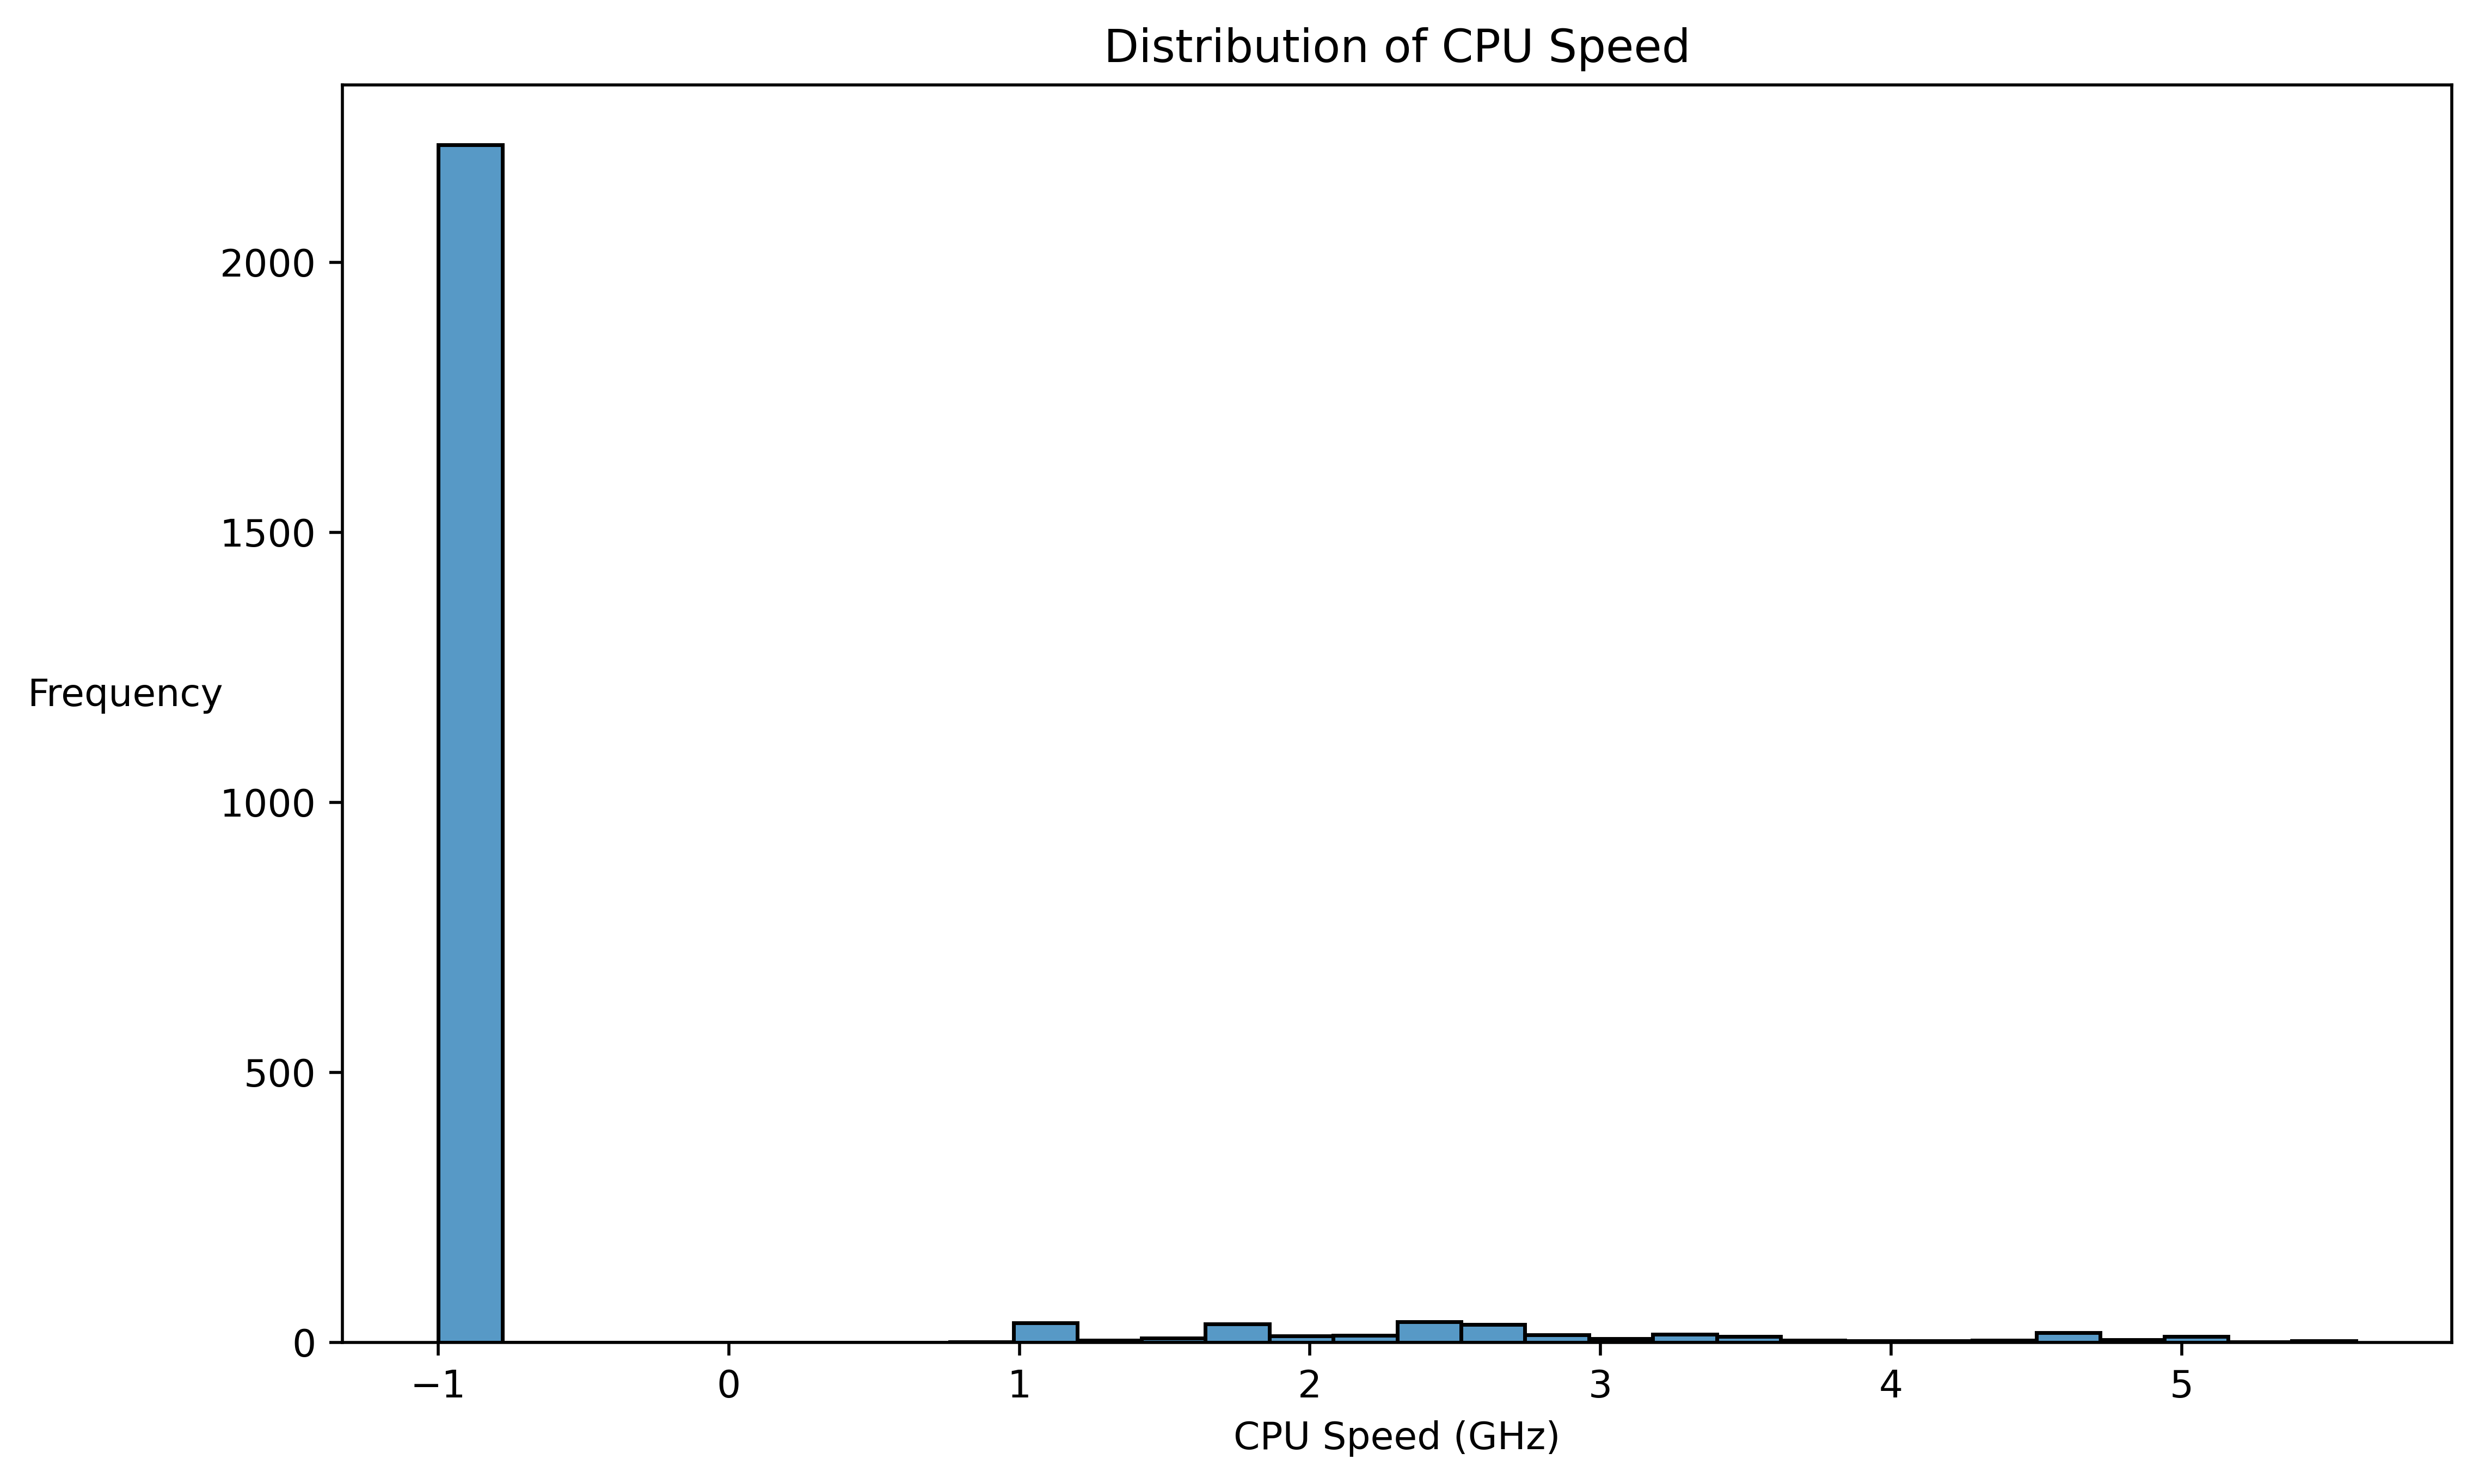

In [1471]:
fig, axes = plt.subplots(figsize=(10,6), dpi=DEFAULT_DPI)
sns.histplot(x='cpu_speed_ghz', data=df[['cpu_speed_ghz']].fillna(-1), bins=30)
plt.title('Distribution of CPU Speed')
plt.xlabel('CPU Speed (GHz)')
plt.ylabel('Frequency')
y_label = axes.set_ylabel('Frequency', rotation=0, labelpad=25)

plt.show()

In [1472]:
float_columns.remove('cpu_speed_ghz')
df = df.drop(columns=['cpu_speed_ghz'])

# Update the types for all the columns and fill missing values with flag value
df[categorical_columns] = df[categorical_columns].fillna('_MISSING_')
df[categorical_columns] = df[categorical_columns].astype(str)
df[integer_columns] = df[integer_columns].astype('Int64')
df[float_columns] = df[float_columns].astype(float)

# Clean string data
df[categorical_columns] = df[categorical_columns].replace('\s+', ' ', regex=True)
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.str.strip(', '))

df = df[df['model'] != '']

df = df.drop_duplicates(ignore_index=True)
df.reset_index(drop=True, inplace=True)

## Final Summary

In [1473]:
print("Shape: ", df.shape)
print("".join(['-'] * 40))
print(df.dtypes)
print("".join(['-'] * 40))
printNumEmpty(df)

Shape:  (2468, 16)
----------------------------------------
brand                  object
model                  object
screen_size_inches    float64
colour                 object
harddisk_gb             Int64
cpu_brand              object
cpu_series             object
cpu_model              object
ram_gb                  Int64
os                     object
special_features       object
graphics               object
graphics_brand         object
graphics_details       object
rating                float64
price_usd             float64
dtype: object
----------------------------------------
COLUMN_NAME           ''    null  % empty
brand                  0       0     0.0%
model                  0       0     0.0%
screen_size_inches     0       9    0.36%
colour                 0       0     0.0%
harddisk_gb            0     143    5.79%
cpu_brand              0       0     0.0%
cpu_series             0       0     0.0%
cpu_model              0       0     0.0%
ram_gb                 0   

## Grouping

One last issue with the data in its current form is some values occur very few times in each column. For example:

In [1474]:

df['graphics_brand'].value_counts()

graphics_brand
_MISSING_                   1240
intel                        572
nvidia                       544
amd                          103
mediatek                       3
imagination technologies       2
arm                            2
apple                          1
qualcomm                       1
Name: count, dtype: int64

This makes the visualisation quite unappealing. 

### Grouping by frequency

A way to solve this is by putting values that dont meet a frequency threshold into a seperate category `'OTHER'`

There is no accepted threshold, hence these thresholds have been determined experimentally to roughly leave a maximum of 10 values. 

The thresholds are stored in a dictionary like this:

In [1475]:
columns = {
    'brand': 0.005,
    'colour': 0.005,
    'cpu_brand': 0.01,
    'os': 0.01,
    'graphics_brand': 0.01,
}

Each column has its values adjusted with the following subroutine using the previously defined thresholds:

In [1476]:
df_grouped = df[:]

other_value = 'OTHER'

for column, cutoff in columns.items():
    
    value_counts = df_grouped[column].value_counts()
    non_empty_rows = df_grouped.shape[0] - value_counts.get('_MISSING_', 0)

    def replace_with_other(value):
        if value == '_MISSING_':
            return value
        return other_value if value_counts.get(value, 0) / non_empty_rows < cutoff else value

    df_grouped[column] = df_grouped[column].apply(replace_with_other)

### Grouping by binning (discrete values)

For some columns such as `cpu_series` it would be better to group the values by binning.

In [1477]:
df_grouped['cpu_series'].value_counts()

cpu_series
i7               1072
i5                694
i9                174
celeron           108
ryzen 7           107
_MISSING_          90
i3                 75
ryzen 5            39
a series           14
pentium            13
ryzen 9            12
ryzen 3            12
r series           12
cortex              7
mobile              6
m1                  5
core m              5
athlon              4
atom                3
athlon silver       2
xeon                2
core 2 duo          2
m2                  2
m1 pro              1
a10                 1
core duo            1
evo i7              1
core m3             1
a4                  1
a6                  1
i7 extreme          1
Name: count, dtype: int64

This is because the two main cpu brands are Intel and AMD, hence only their main lineup of CPUs could be left in the dataset and the rest could be placed into OTHER.

In [1478]:
column = 'cpu_series'

KEEP = ['i3', 'i5', 'i7', 'i9', 'celeron', 'pentium', 'ryzen 3', 'ryzen 5', 'ryzen 7', 'ryzen 9']
cpu_dict = {
    'INTEL_OTHER': ['mobile', 'core m', 'atom', 'xeon', 'core 2 duo', 'i7 extreme', 'evo i7', 'core m3', 'core duo'],

    'AMD_OTHER': ['a series', 'r series', 'athlon', 'athlon silver', 'a4', 'a10', 'a6'],
}

def replace_with_other(value):
    if value == '_MISSING_' or value in KEEP:
        return value
    
    for key, list in cpu_dict.items():
        if value in list:
            return key
    return 'OTHER'

df_grouped[column] = df_grouped[column].apply(replace_with_other)


In [1479]:
df_grouped['cpu_series'].value_counts()

cpu_series
i7             1072
i5              694
i9              174
celeron         108
ryzen 7         107
_MISSING_        90
i3               75
ryzen 5          39
AMD_OTHER        35
INTEL_OTHER      22
OTHER            15
pentium          13
ryzen 9          12
ryzen 3          12
Name: count, dtype: int64

### Grouping by binning (ranges)

Looking at the numerical columns, there are only 2 columns that could be potentially binned, these are `ram_gb` and `harddisk_gb`. The remaining columns such as `screen_size`, `cpu_speed_ghz`, `rating`, and `price` are on a more continuous scale than `ram_gb` and `harddisk_gb`.

This is best shown by plotting a histogram of ram and harddisk values:

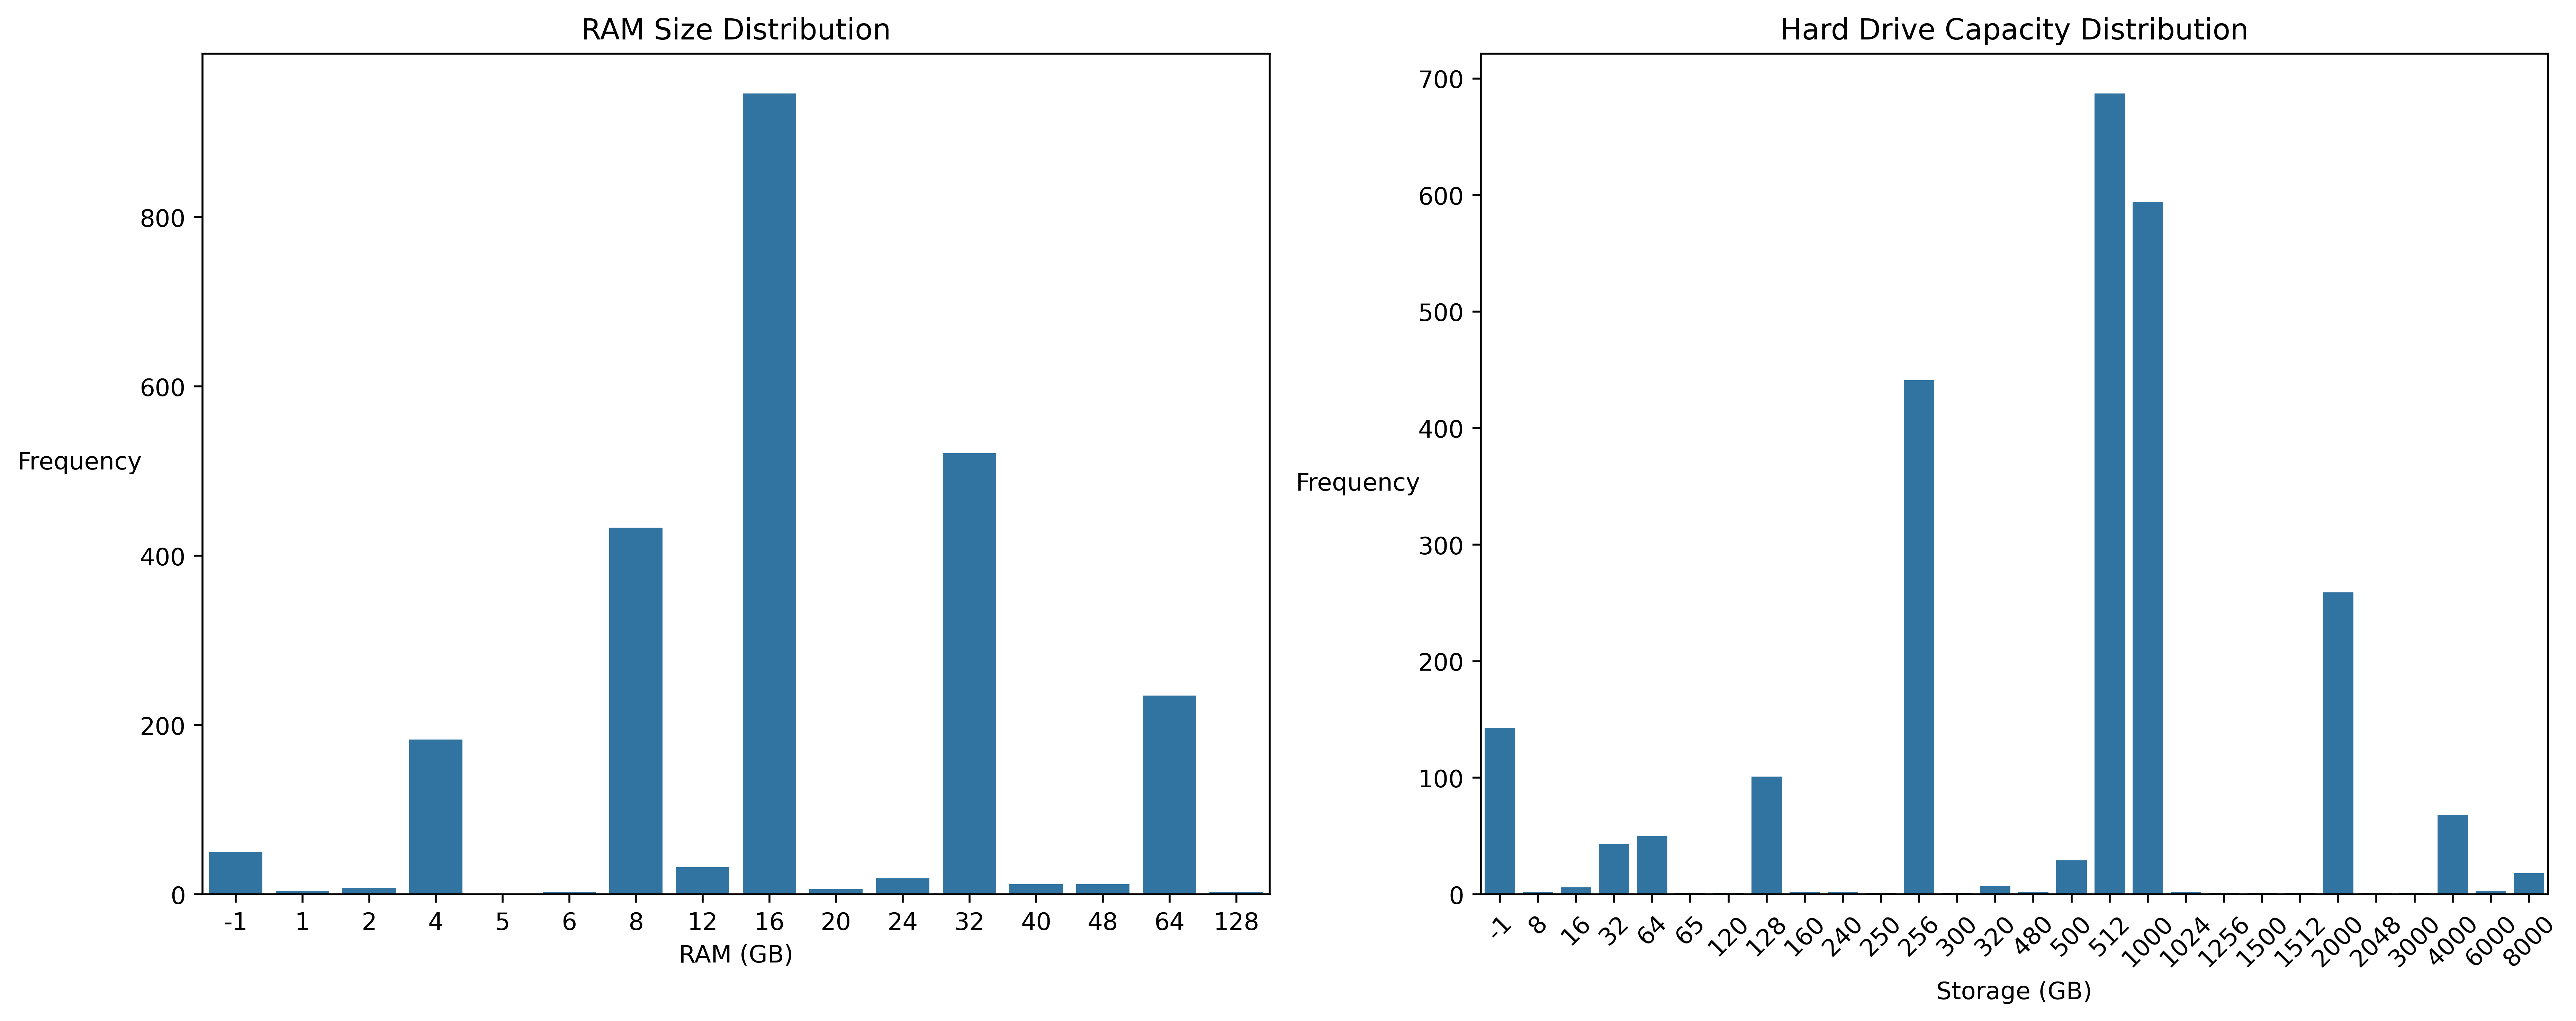

In [1480]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=DEFAULT_DPI)

temp_df = df_grouped[:]
temp_df[['ram_gb', 'harddisk_gb']] = temp_df[['ram_gb', 'harddisk_gb']].fillna(-1)


# Count plot for RAM
sns.countplot(x='ram_gb', data=temp_df, ax=axes[0])
axes[0].set_title('RAM Size Distribution')
axes[0].set_xlabel('RAM (GB)')

y_label = axes[0].set_ylabel('Frequency', rotation=0, labelpad=25)
y_label.set_y(y_label.get_position()[1] + 0)

axes[0].tick_params(axis='x', rotation=0)

# Count plot for Hard Disk
sns.countplot(x='harddisk_gb', data=temp_df, ax=axes[1])
axes[1].set_title('Hard Drive Capacity Distribution')
axes[1].set_xlabel('Storage (GB)')

y_label = axes[1].set_ylabel('Frequency', rotation=0, labelpad=25)
y_label.set_y(y_label.get_position()[1] - 0.025)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("visualisations/ram_harddisk_distribution_before.png")
plt.show()


From this we can see that the values are generally normally distributed, however the data isn't continuous and is concentrated in bars around specific values - more specifically the powers of 2.

The RAM values are too small and specific to be able to bin correctly. Harddisk values are a lot more distributed and hence much easier to bin.

In [1481]:
range = 15 / 100 # Values can be this percent above or below the powers of 2 to be binned there

def mapToPower2(value):
    if pd.isna(value):
        return value

    closestPower2 = 2 ** round(np.log2(value))

    if closestPower2 <= value <= closestPower2 * (1 + range) or closestPower2 * (1 - range) <= value <= closestPower2:
        return closestPower2
    
    return value

df_grouped['harddisk_gb'] = df_grouped['harddisk_gb'].apply(mapToPower2)

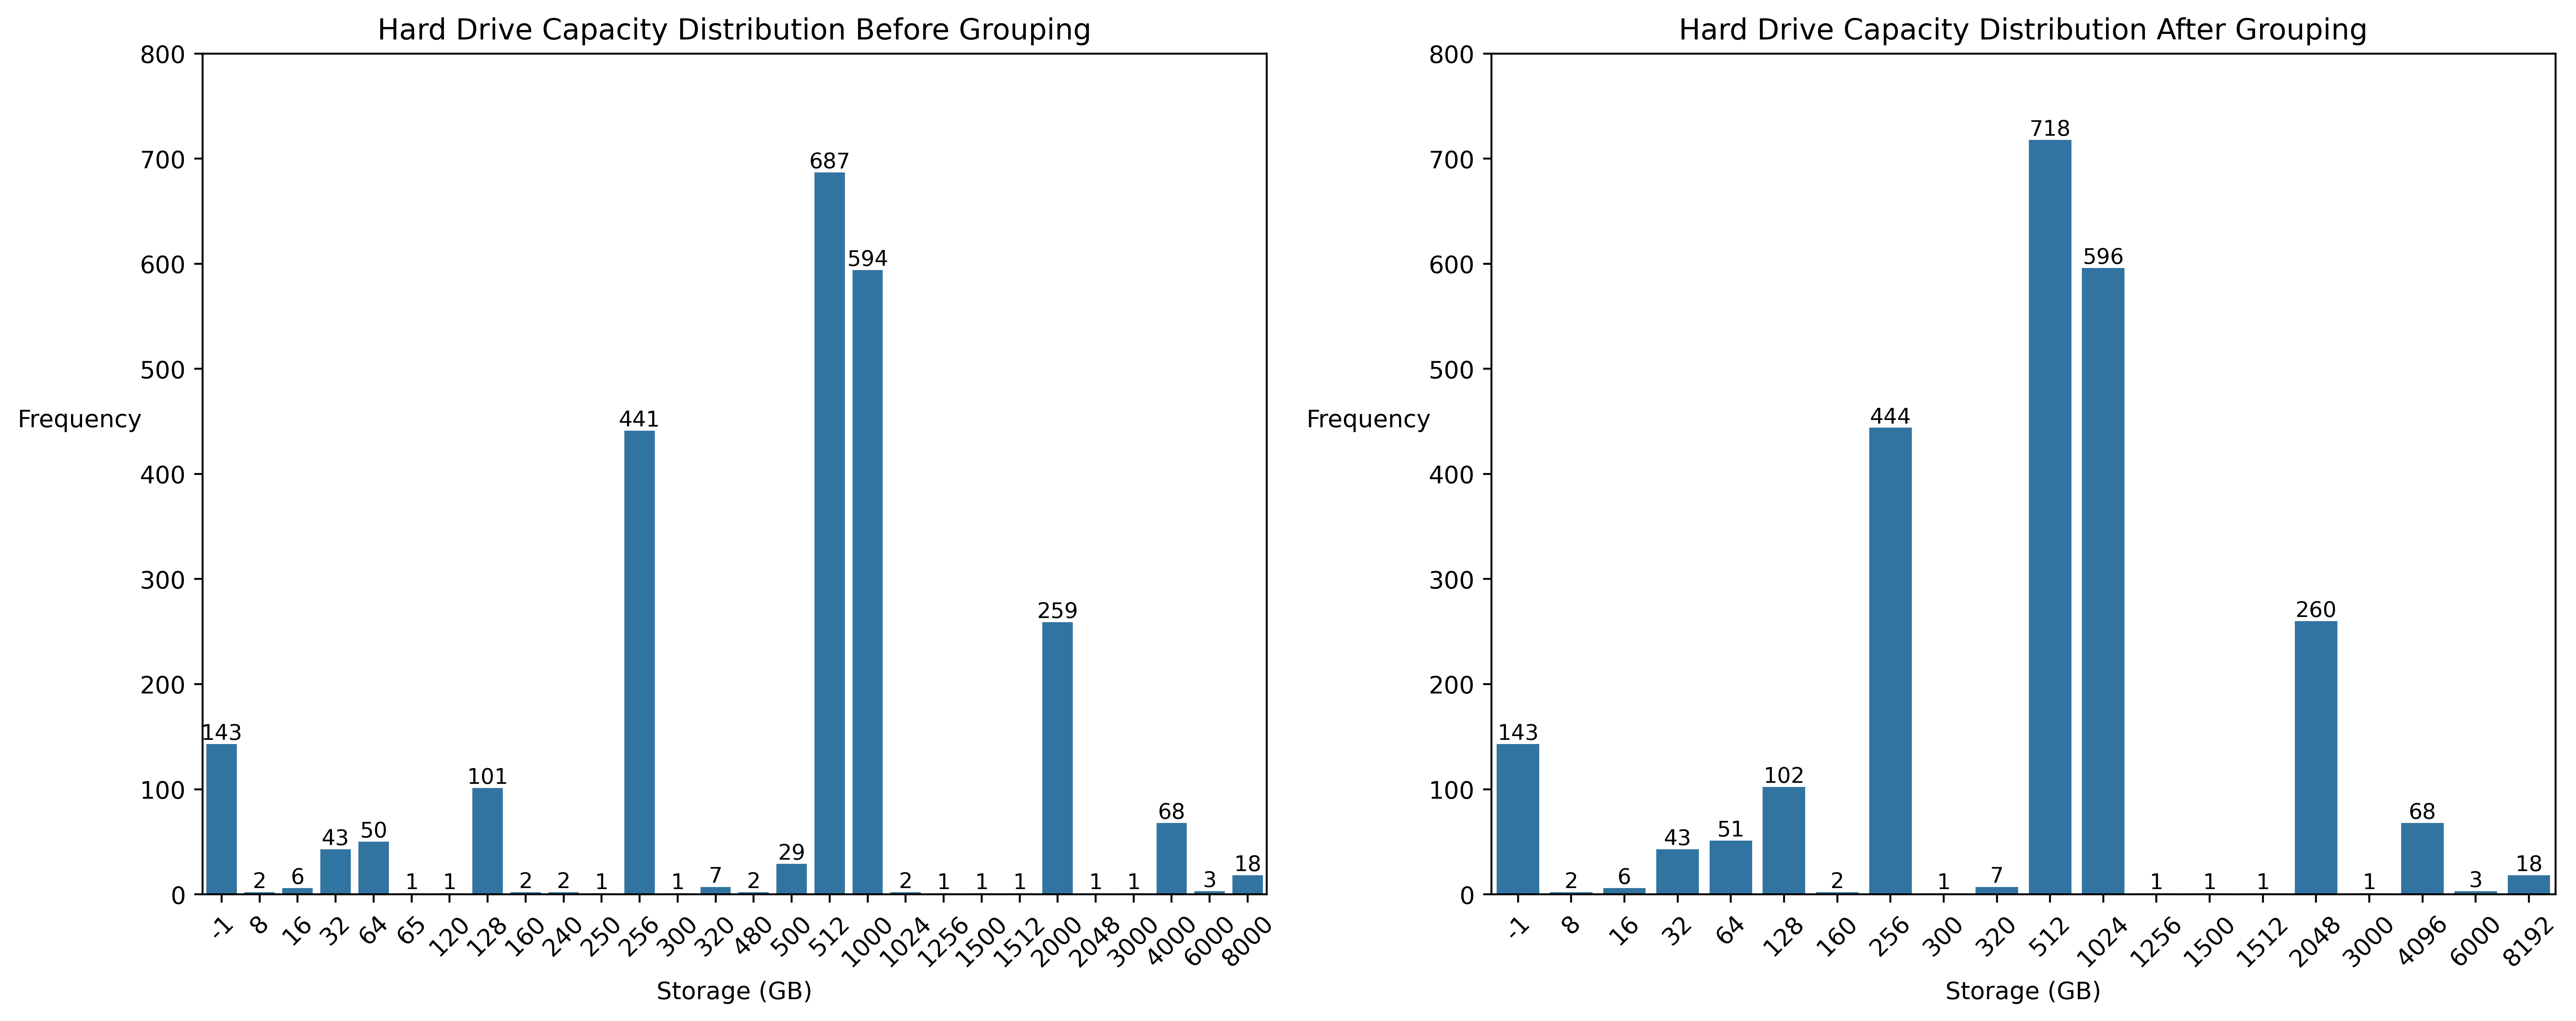

In [1482]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=DEFAULT_DPI)

# Count plot for Hard Disk Before Grouping
sns.countplot(x='harddisk_gb', data=temp_df, ax=axes[0])
axes[0].set_title('Hard Drive Capacity Distribution Before Grouping')

# Count plot for Hard Disk After Grouping
sns.countplot(x='harddisk_gb', data=df_grouped[['harddisk_gb']].fillna(-1), ax=axes[1])
axes[1].set_title('Hard Drive Capacity Distribution After Grouping')

for ax in [0, 1]:
    axes[ax].set_xlabel('Storage (GB)')
    axes[ax].set_ylim(bottom=-0, top=800)
    axes[ax].bar_label(axes[ax].containers[0], fontsize=9)
    y_label = axes[ax].set_ylabel('Frequency', rotation=0, labelpad=25)
    y_label.set_y(y_label.get_position()[1] + 0.05)
    axes[ax].tick_params(axis='x', rotation=45)
    

plt.tight_layout()
plt.savefig("visualisations/ram_harddisk_distribution_comparison.png")
plt.show()


## Boxplots for outliers

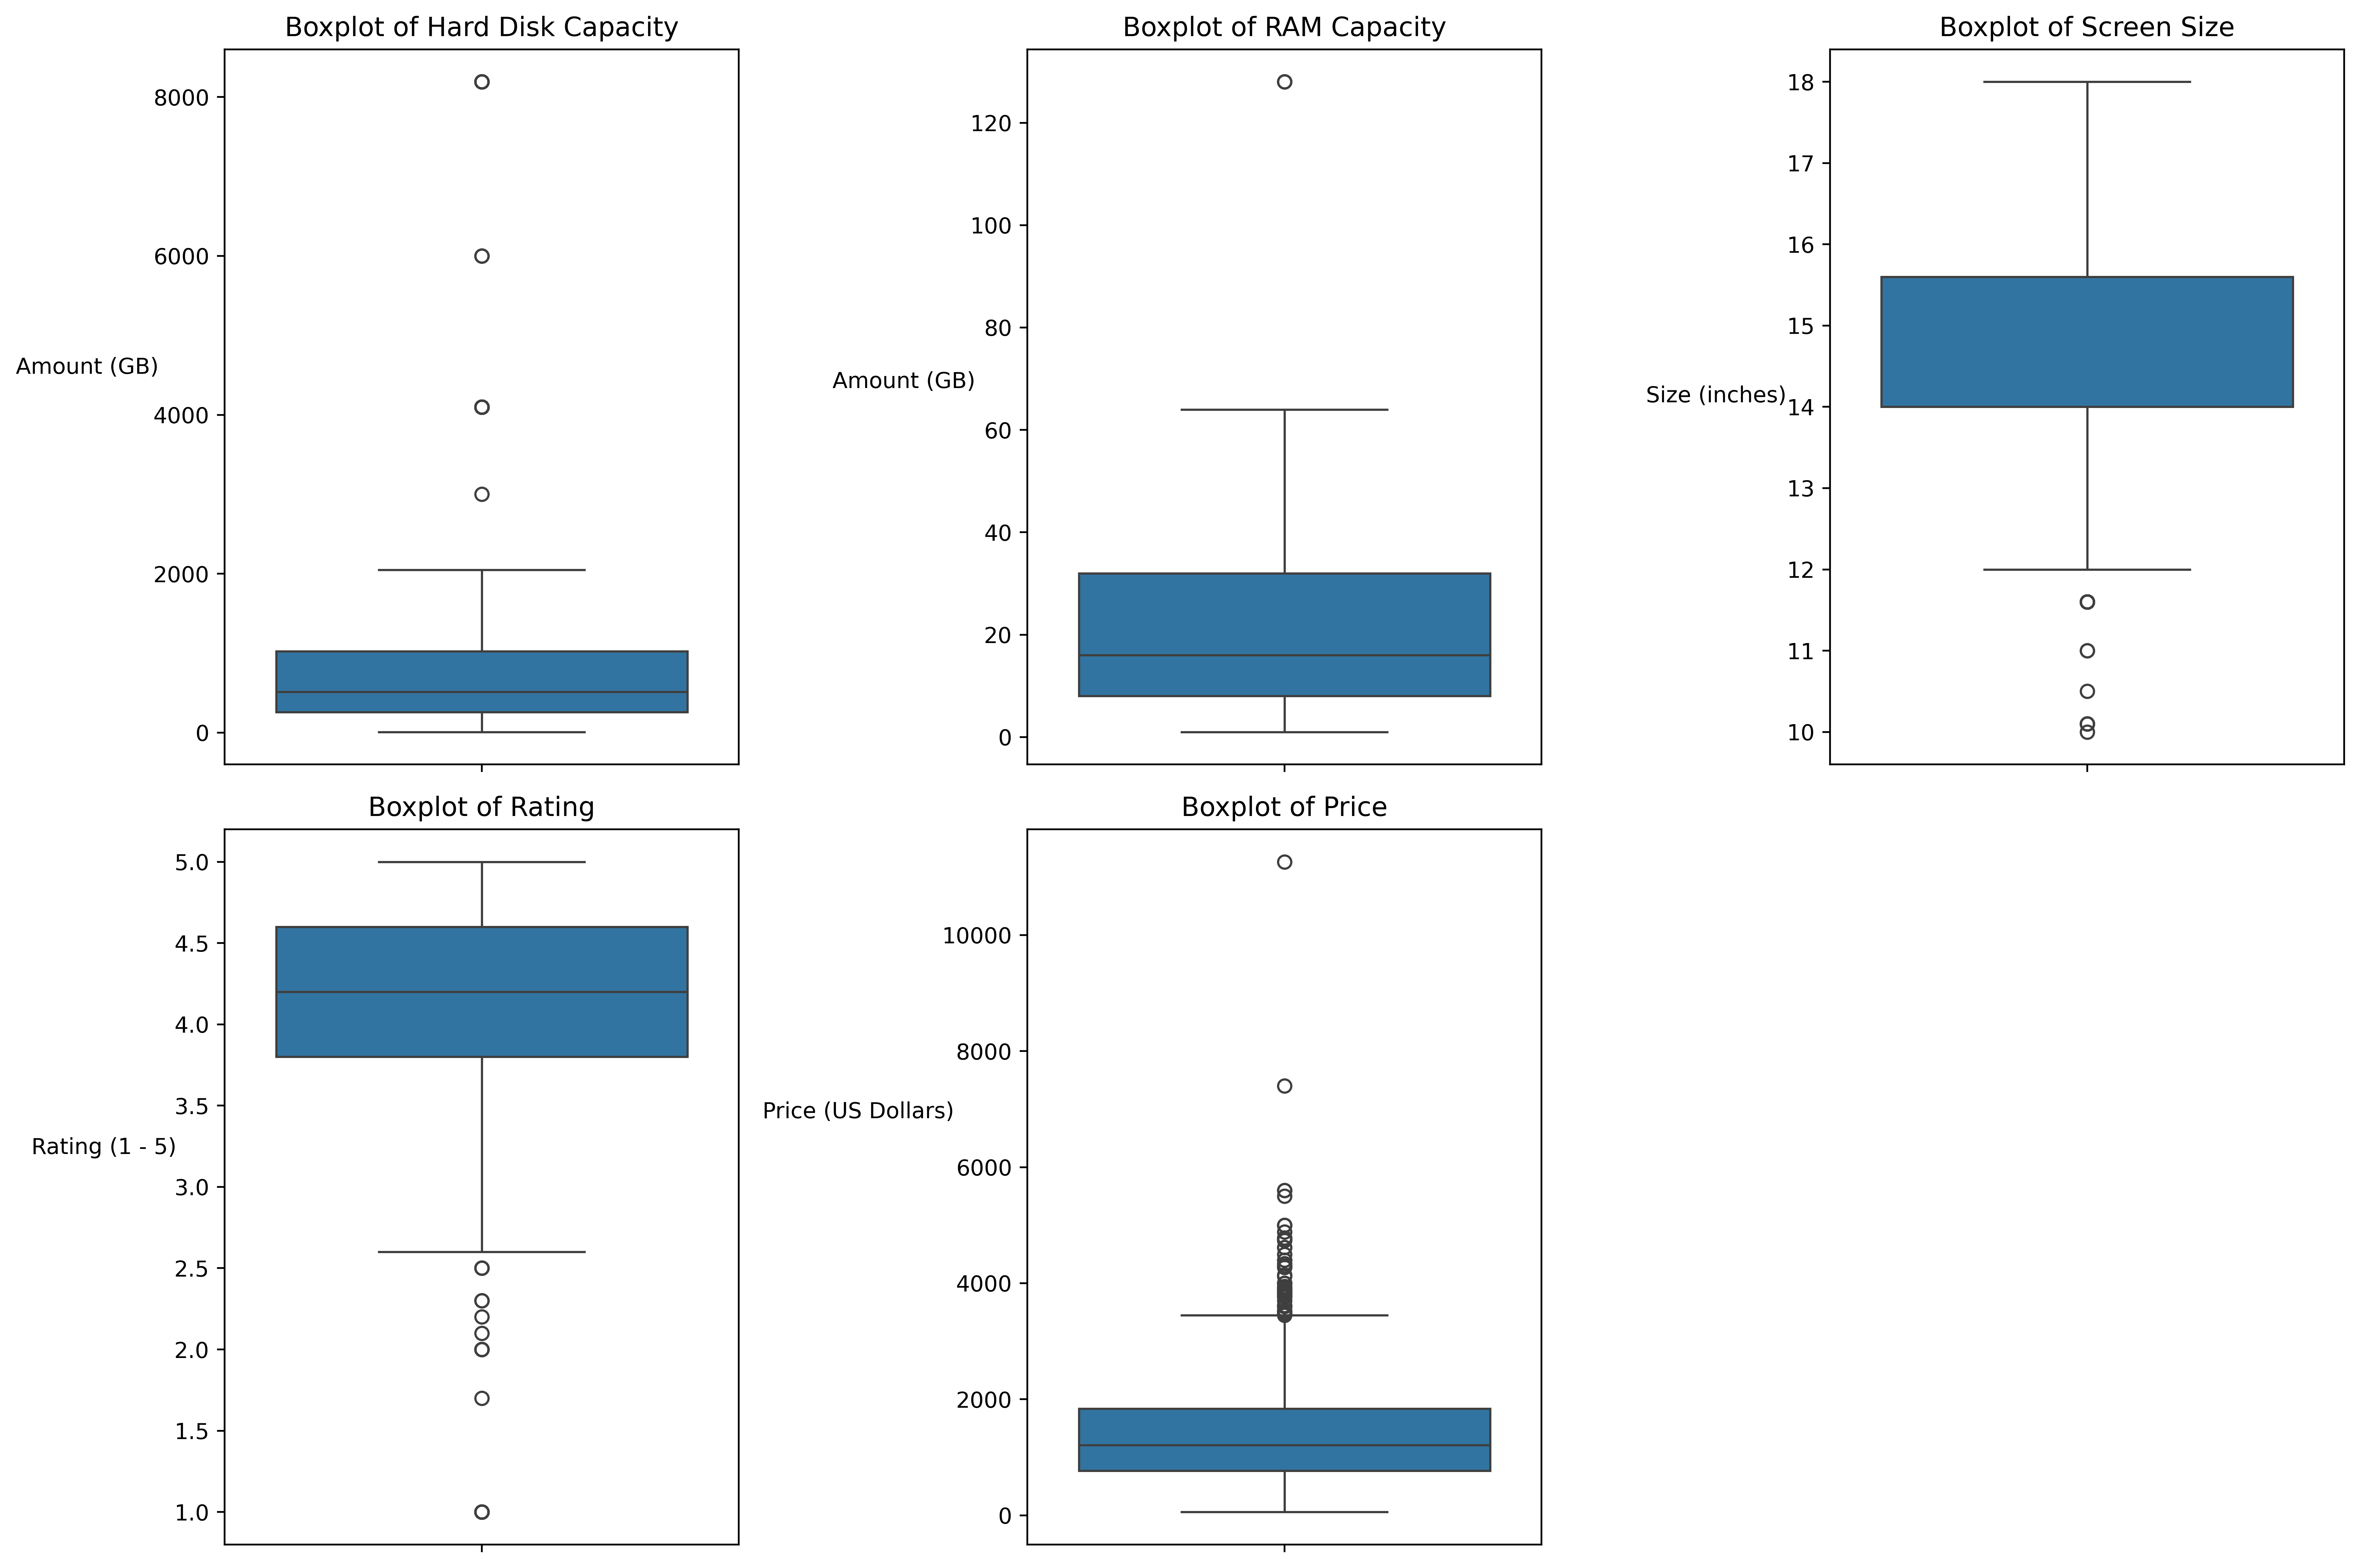

In [1493]:

numerical_columns = integer_columns + float_columns

# Labels for the subplots
labels = [
    ('Boxplot of Hard Disk Capacity', 'Amount (GB)', 30, 0.04),
    ('Boxplot of RAM Capacity', 'Amount (GB)', 30, 0.02),
    ('Boxplot of Screen Size', 'Size (inches)', 32, 0),
    ('Boxplot of Rating', 'Rating (1 - 5)', 32, 0.04),
    ('Boxplot of Price', 'Price (US Dollars)', 38, 0.09)
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=DEFAULT_DPI)

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, (column, (title, ylabel, labelpad, vertical_shift)) in enumerate(zip(numerical_columns, labels)):
    sns.boxplot(y=df_grouped[column], ax=axes[i])
    axes[i].set_title(title)
    y_label = axes[i].set_ylabel(ylabel, rotation=0, labelpad=labelpad)
    y_label.set_y(y_label.get_position()[1] + vertical_shift)

fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig("visualisations/boxplot_numerical.png")
plt.show()


Based on these boxplots for numerical data, we can see that each of the numerical columns has numerical outliers. There however is not enough of a reason remove the outlier rows solely based on the presence of outliers.
- A large harddisk is not indicative of an outlier, the laptop may just have a lot of storage. Even the largest harddisk in the boxplot at 8TB is entirely possible in today's world.
- Similarly to harddisk, 128GB of RAM is rare but possible in a laptop.
- A low rating is also possible, these are subjective ratings that were decided by past customers.
- A high price is entirely possible, this is just a value arbitrarily picked by the sellers.

However, the outliers in the `screen_size` column are implausible. As of December 2023, the highest screen size on a laptop is 21 inches. Hence the outliers are actual outliers.

Lets look at those outliers:

In [1484]:
df_grouped[df_grouped['screen_size_inches'] > 21]

,brand,model,screen_size_inches,colour,harddisk_gb,cpu_brand,cpu_series,cpu_model,ram_gb,os,special_features,graphics,graphics_brand,graphics_details,rating,price_usd
967,hp,pavilion,27.0,black,<NA>,intel,i5,_MISSING_,<NA>,windows 10 home,_MISSING_,_MISSING_,_MISSING_,_MISSING_,4.5,1999.99
1147,OTHER,pos,22.0,black,<NA>,intel,i5,_MISSING_,8,OTHER,_MISSING_,_MISSING_,_MISSING_,_MISSING_,NaN,2320.03


The first is an obviously too big laptop, and the second is a Point-Of-Service system - not even a laptop.

In [1485]:
df_grouped = df_grouped[df_grouped['screen_size_inches'] <= 21]
df = df[df['screen_size_inches'] <= 21]

## Output the cleaned data

The two dataframes are saved as seperate sheets in the excel file.

In [1486]:
with pd.ExcelWriter(DEFAULT_OUT_FILEPATH) as writer:  
    df.to_excel(writer, sheet_name='amazon laptop 2023', index=False)
    df_grouped.to_excel(writer, sheet_name='amazon laptop 2023 grouped', index=False)

# Part 2

Import both the grouped and ungrouped dataframes from the cleaned excel file

In [1487]:
raw_df = pd.read_excel('amazon_laptop_2023_cleaned.xlsx', 'amazon laptop 2023')
df = pd.read_excel('amazon_laptop_2023_cleaned.xlsx', 'amazon laptop 2023 grouped')

In [1488]:
vis_df = df[:]

vis_df['intel_cpu'] = (vis_df['cpu_brand'] == 'intel').astype(int)
vis_df['amd_cpu'] = (vis_df['cpu_brand'] == 'amd').astype(int)

vis_df['dedicated_graphics'] = (vis_df['graphics'] == 'dedicated').astype(int)

/tmp/ipykernel_67536/1327074428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vis_df['intel_cpu'] = (vis_df['cpu_brand'] == 'intel').astype(int)
/tmp/ipykernel_67536/1327074428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vis_df['amd_cpu'] = (vis_df['cpu_brand'] == 'amd').astype(int)
/tmp/ipykernel_67536/1327074428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

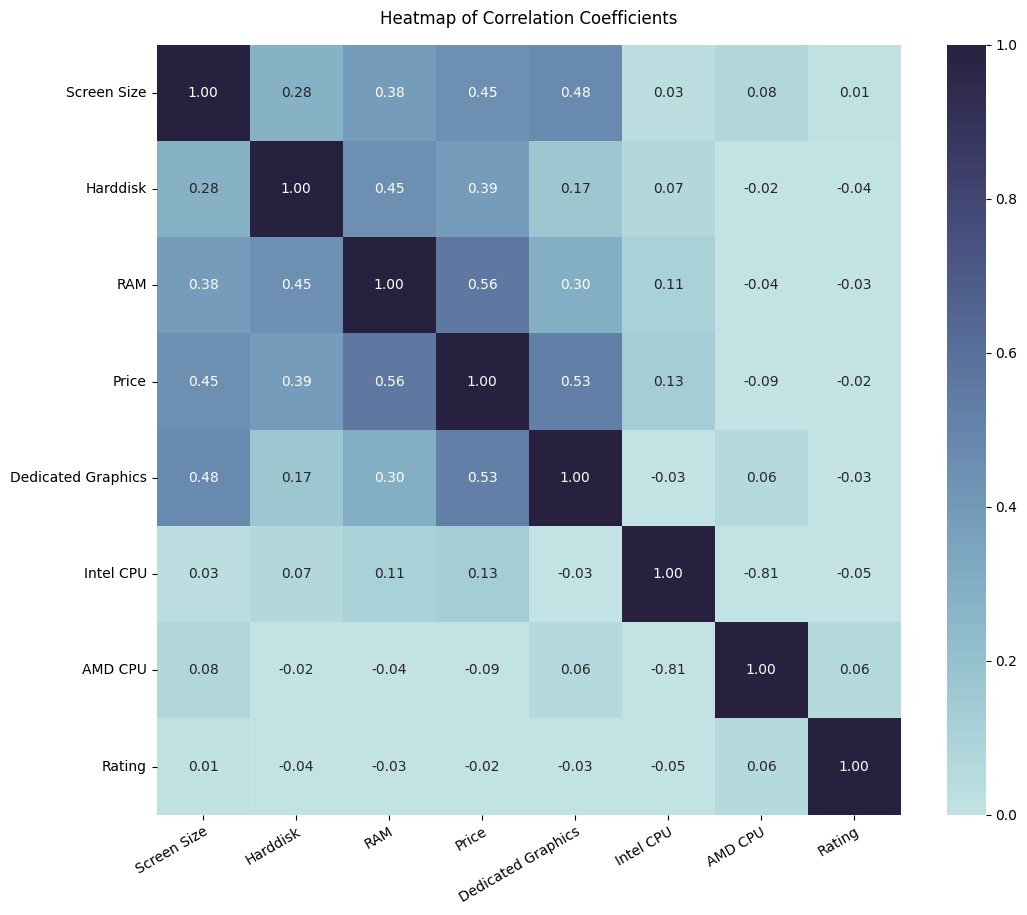

In [1489]:
# Calculating the correlation matrix
columns = ['screen_size_inches', 'harddisk_gb', 'ram_gb', 'price_usd', 'dedicated_graphics', 'intel_cpu', 'amd_cpu', 'rating']
correlation_matrix = vis_df[columns].corr()

# Plotting the heatmap
fig = plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, vmin=0, vmax=1, annot=True, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), fmt='.2f')
axes = fig.axes[0]
axes.tick_params(axis='x', rotation=45)
new_labels = ['Screen Size', 'Harddisk', 'RAM', 'Price', 'Dedicated Graphics', 'Intel CPU', 'AMD CPU', 'Rating']
axes.set_xticklabels(new_labels, rotation=30, horizontalalignment='right', rotation_mode='anchor')
axes.set_yticklabels(new_labels)
plt.title('Heatmap of Correlation Coefficients', pad=15)
plt.savefig("visualisations/correlation_matrix.png")
plt.show()